In [19]:
# Import Modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, add
from tensorflow.keras.layers import Activation, Dense, Flatten, Dropout, BatchNormalization, Concatenate, Add, Input
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler 
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras import applications
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from glob import glob
from PIL import Image # pip install PILLOW
from tqdm import tqdm

# conda install opencv-python
import os, sys, cv2, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, datetime, time, PIL
print(sys.executable) # See where your python.exe is located
print(os.getcwd()) # See your current working directory
print(tf.__version__) # Display the version of Tensorflow

C:\Users\chris\anaconda3\envs\projects\python.exe
C:\Users\chris\Downloads
2.8.0


In [28]:
# for each file in (sub)/folder of data folder count the number of ".jpg" images 
import os
for x in os.walk("./data"): # x[0] --> directories only not images/files
    print(x[0], len([x[0]+"/"+f for f in os.listdir(x[0]) if f.endswith("g")]))

./data 0
./data\train 0
./data\train\bacterial pneumonia 3636
./data\train\no disease 2026
./data\train\viral pneumonia 2011
./data\val 0
./data\val\bacterial pneumonia 336
./data\val\no disease 185
./data\val\viral pneumonia 182


In [21]:
batch_size = 16 # 64 !!!!!!
IMG_WIDTH = 224
IMG_HEIGHT = 224
CHANNELS = 3
CLASSES = 3
train_dir = "./data/train" # all training dataset + augmentation
validation_dir = './data/val'
test_dir = './dataset/test_images/' # dataset --> random,  './dataset2/test_images/'
class_names = ["no disease", "bacterial pneumonia", "viral pneumonia"]
seed = 28
# os.environ['PYTHONHASHSEED'] = "14"
# import random
# random.seed(seed)
# np.random.seed(seed)
tf.random.set_seed(seed)

In [22]:
IMG_WIDTH = 380
IMG_HEIGHT = 380

In [23]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    # rescale=1./255, # None
    rotation_range=30, # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1, # randomly shi"ft images horizontally (fraction of total width)
    height_shift_range=0.1, # randomly shift images vertically (fraction of total height)
    zoom_range = 0.2, # Randomly zoom image 
    fill_mode='reflect', # constant cval=125# {"constant", "nearest", "reflect" or "wrap"}.
    brightness_range=[0.2,1.2], # brightness
    horizontal_flip=True # randomly horizontal flip images
#     vertical_flip=True, # randomly vertical flip images  
#     channel_shift_range=100
#     featurewise_center=False,
#     samplewise_center=False,
#     featurewise_std_normalization=False,
#     samplewise_std_normalization=False,
#     zca_whitening=False,
    )

validation_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input) # rescale=1./255, # None
test_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input) # rescale=1./255, # None
#validation_datagen = image.ImageDataGenerator(rescale=1./255) # preprocessing_function=preprocess_input
#test_datagen = image.ImageDataGenerator(rescale=1./255) # preprocessing_function=preprocess_input

In [24]:
train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=(IMG_WIDTH,IMG_HEIGHT),
            batch_size=batch_size,
            # class_mode='sparse',
            seed=seed,
            shuffle=True,
            classes=class_names)

validation_generator = validation_datagen.flow_from_directory(
            validation_dir,
            target_size=(IMG_WIDTH,IMG_HEIGHT),
            batch_size=batch_size,
            # class_mode='sparse', # "categorical", "binary", "sparse", "input", or None.
            seed=seed,
            shuffle=True,
            classes=class_names)
    
test_generator = test_datagen.flow_from_directory(
            test_dir,
            target_size=(IMG_WIDTH,IMG_HEIGHT),
            batch_size=1,
            # class_mode='sparse',
            seed=seed,
            shuffle=False,
            classes=class_names)

# Found 6804 images belonging to 3 classes. 8967
# Found 700 images belonging to 3 classes.  700
# Found 1168 images belonging to 3 classes. 1168

Found 7673 images belonging to 3 classes.
Found 703 images belonging to 3 classes.
Found 1168 images belonging to 3 classes.


In [25]:
# Add class weight for imabalanced dataset
from collections import Counter
counter = Counter(train_generator.classes) # Counter({0: 1927, 1: 3449, 2: 1897})
max_val = float(max(counter.values())) # 3449.0
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
print(class_weights) # {0: 1.7898287493513234, 1: 1.0, 2: 1.8181338956246704}

{0: 1.7946692991115498, 1: 1.0, 2: 1.808055693684734}


In [26]:
# Display all models from tensorflow.keras import applications
dir(applications)

['DenseNet121',
 'DenseNet169',
 'DenseNet201',
 'EfficientNetB0',
 'EfficientNetB1',
 'EfficientNetB2',
 'EfficientNetB3',
 'EfficientNetB4',
 'EfficientNetB5',
 'EfficientNetB6',
 'EfficientNetB7',
 'EfficientNetV2B0',
 'EfficientNetV2B1',
 'EfficientNetV2B2',
 'EfficientNetV2B3',
 'EfficientNetV2L',
 'EfficientNetV2M',
 'EfficientNetV2S',
 'InceptionResNetV2',
 'InceptionV3',
 'MobileNet',
 'MobileNetV2',
 'MobileNetV3Large',
 'MobileNetV3Small',
 'NASNetLarge',
 'NASNetMobile',
 'ResNet101',
 'ResNet101V2',
 'ResNet152',
 'ResNet152V2',
 'ResNet50',
 'ResNet50V2',
 'VGG16',
 'VGG19',
 'Xception',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_sys',
 'densenet',
 'efficientnet',
 'efficientnet_v2',
 'imagenet_utils',
 'inception_resnet_v2',
 'inception_v3',
 'mobilenet',
 'mobilenet_v2',
 'mobilenet_v3',
 'nasnet',
 'resnet',
 'resnet50',
 'resnet_v2',
 'vgg16',
 'vgg19',
 'xception']

In [8]:
# Model 1: Feature extraction transfer learning on 100% of the data with data augmentation frem Keras (Not as Layer)
# Setup input shape and base model, freezing the base model layers
input_shape = (IMG_WIDTH,IMG_HEIGHT,CHANNELS) # (224, 224, 3)
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)
# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# Create input layer
# 3. Create inputs into the base model
inputs = layers.Input(shape=input_shape, name="input_layer")

# # Add in data augmentation Sequential model as a layer
# x = data_augmentation(inputs)
# # Give base_model inputs (after augmentation) and don't train it
# x = base_model(x, training=False)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
# Check data shape after passing it to base_model
# print(f"Shape after base_model: {x.shape}")

# Pool output features of base model
# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
# print(f"After GlobalAveragePooling2D(): {x.shape}")

# Include dropout with probability of 0.2 to avoid overfitting
x = tf.keras.layers.Dropout(.2, seed=seed)(x)
# Add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(128,activation='relu')(x) # dense layer 1
x=Dense(64,activation='relu')(x) # dense layer 2

# Put a dense layer on as the output
# 7. Create the output activation layer
outputs = layers.Dense(CLASSES, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
# 8. Combine the inputs with the outputs into a model
model = keras.Model(inputs, outputs)

# Compile the model
base_learning_rate = 0.0001 # 0.0001

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              metrics=["accuracy"])

print("Base Model:",base_model._name)

Base Model: efficientnetv2-b0


In [9]:
print(len(base_model.trainable_variables))
base_model.summary()

0
Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   0           ['rescaling[0][0]']              
                                3)                                              

                                                                                                  
 block3b_expand_activation (Act  (None, None, None,   0          ['block3b_expand_bn[0][0]']      
 ivation)                       192)                                                              
                                                                                                  
 block3b_project_conv (Conv2D)  (None, None, None,   9216        ['block3b_expand_activation[0][0]
                                48)                              ']                               
                                                                                                  
 block3b_project_bn (BatchNorma  (None, None, None,   192        ['block3b_project_conv[0][0]']   
 lization)                      48)                                                               
                                                                                                  
 block3b_a

 lization)                      96)                                                               
                                                                                                  
 block4b_add (Add)              (None, None, None,   0           ['block4b_project_bn[0][0]',     
                                96)                               'block4a_project_bn[0][0]']     
                                                                                                  
 block4c_expand_conv (Conv2D)   (None, None, None,   36864       ['block4b_add[0][0]']            
                                384)                                                              
                                                                                                  
 block4c_expand_bn (BatchNormal  (None, None, None,   1536       ['block4c_expand_conv[0][0]']    
 ization)                       384)                                                              
          

 block5b_expand_bn (BatchNormal  (None, None, None,   2688       ['block5b_expand_conv[0][0]']    
 ization)                       672)                                                              
                                                                                                  
 block5b_expand_activation (Act  (None, None, None,   0          ['block5b_expand_bn[0][0]']      
 ivation)                       672)                                                              
                                                                                                  
 block5b_dwconv2 (DepthwiseConv  (None, None, None,   6048       ['block5b_expand_activation[0][0]
 2D)                            672)                             ']                               
                                                                                                  
 block5b_bn (BatchNormalization  (None, None, None,   2688       ['block5b_dwconv2[0][0]']        
 )        

                                                                                                  
 block5d_dwconv2 (DepthwiseConv  (None, None, None,   6048       ['block5d_expand_activation[0][0]
 2D)                            672)                             ']                               
                                                                                                  
 block5d_bn (BatchNormalization  (None, None, None,   2688       ['block5d_dwconv2[0][0]']        
 )                              672)                                                              
                                                                                                  
 block5d_activation (Activation  (None, None, None,   0          ['block5d_bn[0][0]']             
 )                              672)                                                              
                                                                                                  
 block5d_s

 )                              672)                                                              
                                                                                                  
 block6a_activation (Activation  (None, None, None,   0          ['block6a_bn[0][0]']             
 )                              672)                                                              
                                                                                                  
 block6a_se_squeeze (GlobalAver  (None, 672)         0           ['block6a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6a_se_reshape (Reshape)   (None, 1, 1, 672)    0           ['block6a_se_squeeze[0][0]']     
                                                                                                  
 block6a_s

 block6c_se_reshape (Reshape)   (None, 1, 1, 1152)   0           ['block6c_se_squeeze[0][0]']     
                                                                                                  
 block6c_se_reduce (Conv2D)     (None, 1, 1, 48)     55344       ['block6c_se_reshape[0][0]']     
                                                                                                  
 block6c_se_expand (Conv2D)     (None, 1, 1, 1152)   56448       ['block6c_se_reduce[0][0]']      
                                                                                                  
 block6c_se_excite (Multiply)   (None, None, None,   0           ['block6c_activation[0][0]',     
                                1152)                             'block6c_se_expand[0][0]']      
                                                                                                  
 block6c_project_conv (Conv2D)  (None, None, None,   221184      ['block6c_se_excite[0][0]']      
          

                                                                                                  
 block6e_se_excite (Multiply)   (None, None, None,   0           ['block6e_activation[0][0]',     
                                1152)                             'block6e_se_expand[0][0]']      
                                                                                                  
 block6e_project_conv (Conv2D)  (None, None, None,   221184      ['block6e_se_excite[0][0]']      
                                192)                                                              
                                                                                                  
 block6e_project_bn (BatchNorma  (None, None, None,   768        ['block6e_project_conv[0][0]']   
 lization)                      192)                                                              
                                                                                                  
 block6e_a

                                192)                                                              
                                                                                                  
 block6g_project_bn (BatchNorma  (None, None, None,   768        ['block6g_project_conv[0][0]']   
 lization)                      192)                                                              
                                                                                                  
 block6g_add (Add)              (None, None, None,   0           ['block6g_project_bn[0][0]',     
                                192)                              'block6f_add[0][0]']            
                                                                                                  
 block6h_expand_conv (Conv2D)   (None, None, None,   221184      ['block6g_add[0][0]']            
                                1152)                                                             
          

In [10]:
print(len(model.trainable_variables))
# Check out model summary
model.summary() 

# Total params: 4,053,414
# Trainable params: 3,843 = Pooling 1280 * 3 + 3 = 3840 + 3
# Non-trainable params: 4,049,571

# Total params: 4,221,990
# Trainable params: 172,419
# Non-trainable params: 4,049,571

# dropout_1 (Dropout) (None, 1280)  0                                                   
# dense_2 (Dense) (None, 128) 163968 = (1280 * 128)weights + (128)bias = 163840 + 128                       
# dense_3 (Dense) (None, 64) 8256 = 128 * 64 + 64    
# output_ layer (Dense) (None, 3) 195 = 64 * 3 + 3

print("Trainable parameters:",163968 + 8256 + 195)

6
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 64)                8256

In [11]:
# Check layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_add False
20 block3a_expand_conv False
21 block3a_expand_bn False
22 block3a_expand_activation False
23 block3a_project_conv False
24 block3a_project_bn False
25 block3b_expand_conv False
26 block3b_expand_bn False
27 block3b_expand_activation False
28 block3b_project_conv False
29 block3b_project_bn False
30 block3b_add False
31 block4a_expand_conv False
32 block4a_expand_bn False
33 block4a_expand_activation False
34 block4a_dwconv2 False
35 block4a_bn False
36 block4a_activation 

In [10]:
# TensorBoard provides measurements and visualizations needed during a Deep Learning workflow.
# https://www.tensorflow.org/tensorboard/get_started
# %reload_ext tensorboard
# Load the TensorBoard notebook extension
%load_ext tensorboard
# start TensorBoard within the notebook or open it to browser: http://localhost:6006
%tensorboard --logdir logs
# C:\Users\chris\AppData\Local\Temp --> clean-up

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


http://localhost:6006

### EfficientNetV2B0

In [93]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

In [14]:
%%time
# No fine-tuning!
print("Feature extraction Transfer Learning on",base_model._name,"with ImageNet weights")

earlystop = EarlyStopping(monitor = 'val_accuracy', # 'val_loss', 'val_accuracy' # mode:{"auto", "min", "max"}
                          min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True) 

# Setup checkpoint path  # note: remember saving directly to Colab is temporary
checkpoint_path = "checkpointsV2B0/basemodelV2B0-epoch_{epoch:02d}-acc_{val_accuracy:.4f}/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
             save_weights_only=False, # set to False to save the entire model
             save_best_only=False, # set to True to save only the best model instead of a model every epoch 
             save_freq="epoch", # save every epoch
             # monitor='val_acc'
             # mode='auto'                                   
             verbose=0) # 1 --> Epoch 1: saving model to model_checkpoints_weights\checkpoint.ckpt 

import datetime
logdir = os.path.join("logs",base_model._name)
# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logdir,
                                              histogram_freq=1,
                                              write_graph=True,
                                              write_images=False,
                                              # write_steps_per_second=False,
                                              update_freq='epoch',
                                              # profile_batch=2,
                                              # embeddings_metadata=None
                                              embeddings_freq=1)

callbacks = [earlystop, checkpoint, tensorboard] # we put our callbacks into a callback list

STEP_SIZE_TRAIN=train_generator.n // train_generator.batch_size # - 455
STEP_SIZE_VALID=validation_generator.n  // validation_generator.batch_size # - 70
# STEP_SIZE_VALID=test_generator.n  // test_generator.batch_size

# initial_epochs= history.epoch[-1]+1
epochs = 20
# total_epochs = initial_epochs + epochs 
history = model.fit(train_generator, # model.fit_generator is deprecated
                             steps_per_epoch=STEP_SIZE_TRAIN,
                             # initial_epoch=initial_epochs,
                             epochs=epochs, # epochs=total_epochs epochs          
                             validation_data=validation_generator, # validation_split=13.04, test_generator,  
                             validation_steps=STEP_SIZE_VALID,
                             callbacks = callbacks, # add earlystop,  checkpoint & TensorBoard
                             class_weight=class_weights) # Add class weight for imabalanced dataset

print(history.history)

Feature extraction Transfer Learning on efficientnetv2-b0 with ImageNet weights
Epoch 1/20
479/479 [==============================] - 277s 549ms/step - loss: 1.0918 - accuracy: 0.6540 - val_loss: 0.6003 - val_accuracy: 0.7471
Epoch 2/20
479/479 [==============================] - 269s 562ms/step - loss: 0.8678 - accuracy: 0.7306 - val_loss: 0.5540 - val_accuracy: 0.7733
Epoch 3/20
479/479 [==============================] - 259s 539ms/step - loss: 0.8341 - accuracy: 0.7465 - val_loss: 0.5177 - val_accuracy: 0.7834
Epoch 4/20
479/479 [==============================] - 265s 553ms/step - loss: 0.8124 - accuracy: 0.7460 - val_loss: 0.5010 - val_accuracy: 0.7965
Epoch 5/20
479/479 [==============================] - 276s 577ms/step - loss: 0.7854 - accuracy: 0.7585 - val_loss: 0.5147 - val_accuracy: 0.7892
Epoch 6/20
479/479 [==============================] - 274s 572ms/step - loss: 0.7759 - accuracy: 0.7584 - val_loss: 0.5162 - val_accuracy: 0.7834
Epoch 7/20
479/479 [========================

In [15]:
# Save model and store it to Google Drive
model.save("EfficientNetV2B0_feature-extraction_TL") # without tuning

INFO:tensorflow:Assets written to: EfficientNetV2B0_feature-extraction_TL\assets


In [ ]:
# Evaluate on the test data
results = model.evaluate(test_generator)
results

# model= tf.keras.models.load_model("EfficientNetV2B0_feature-extraction_TL")
# model.summary()

In [13]:
%%time
# Time to fine-tune! Fine-Tuning Transfer Learning
print("Fine-Tuning Transfer Learning on",base_model._name,"with previous checkpoint after 40 epocks on ImageNet weights")
# We're going to continue training on from where our previous model finished.
# Since it trained for 10 epochs, our fine-tuning will begin on the epoch 10 and continue for another e.g. 100 epochs.
# Unfreeze more & more layers for tuning  --> step by step

# Freeze all layers except for the
unfreeze = [7, 21, 35, 49, 63, 77, 91, 105] # list(range(10,100,10)) # [10, 20, 30, 40, 50, 60, 70, 80, 90]
for f in unfreeze:
    base_model.trainable = True
    for layer in base_model.layers[:-f]: # unfreeze last f layers [10, 20, 30, 40, 50, 60, 70, 80, 90]
        layer.trainable = False

    # Recompile the model (always recompile after any adjustments to a model)
    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                  metrics=["accuracy"])
    
    # Setup checkpoint path
    checkpoint_path = "checkpoints_V2B0/fine-tuning-unfreeze_{}".format(f)
    print("fine-tuning unfreeze {}".format(f))
    checkpoint_path = checkpoint_path + "-epoch_{epoch:02d}-acc_{val_accuracy:.4f}/checkpoint.ckpt"
    # print(checkpoint_path)
    
    # Create a ModelCheckpoint callback that saves the model's weights only
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                 save_weights_only=False, # set to False to save the entire model
                 save_best_only=False, # set to True to save only the best model instead of a model every epoch 
                 save_freq="epoch", # save every epoch
                 # monitor='val_acc'
                 # mode='auto'                                    
                 verbose=0) # 1 --> Epoch 1: saving model to model_checkpoints_weights\checkpoint.ckpt 
    
    earlystop = EarlyStopping(monitor = 'val_accuracy', # 'val_loss', 'val_accuracy' # mode:{"auto", "min", "max"}
                              min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True) # patience=10
    
    callbacks = [earlystop, checkpoint, tensorboard] # we put our call backs into a callback list

    STEP_SIZE_TRAIN=train_generator.n // train_generator.batch_size
    STEP_SIZE_VALID=validation_generator.n  // validation_generator.batch_size
    # STEP_SIZE_VALID=test_generator.n  // test_generator.batch_size
    
    initial_epochs= history.epoch[-1]+1                
    epochs = 20 # 10 or 15 or 20
    total_epochs = initial_epochs + epochs                
    # Refit the model (same as model except with more trainable layers)
    history = model.fit(train_generator, # model.fit_generator is deprecated
                                 steps_per_epoch=STEP_SIZE_TRAIN,
                                 initial_epoch=initial_epochs,
                                 epochs=total_epochs,          
                                 validation_data=test_generator, # test_generator,  validation_generator
                                 validation_steps=STEP_SIZE_VALID,
                                 callbacks = callbacks, # add earlystop
                                 class_weight=class_weights) # Add class weight for imabalanced dataset
    
    print(history.history)
    # print(model.evaluate(test_generator))

# Save model and store it to Google Drive
model.save("EfficientNetV2B0_fine-tuning_TL_non-stop") # with tuning

saved_model_results = model.evaluate(test_generator)
print(saved_model_results)


Fine-Tuning Transfer Learning on efficientnetv2-b0 with previous checkpoint after 40 epocks on ImageNet weights
fine-tuning unfreeze 7
Epoch 21/40
479/479 [==============================] - 268s 541ms/step - loss: 0.7588 - accuracy: 0.7700 - val_loss: 0.2196 - val_accuracy: 0.9070
Epoch 22/40
479/479 [==============================] - 259s 540ms/step - loss: 0.6923 - accuracy: 0.7846 - val_loss: 0.1893 - val_accuracy: 0.8837
Epoch 23/40
479/479 [==============================] - 266s 555ms/step - loss: 0.6602 - accuracy: 0.7980 - val_loss: 0.1690 - val_accuracy: 0.9070
Epoch 24/40
479/479 [==============================] - 255s 531ms/step - loss: 0.6397 - accuracy: 0.8023 - val_loss: 0.1262 - val_accuracy: 0.9535
Epoch 25/40
479/479 [==============================] - 249s 520ms/step - loss: 0.6223 - accuracy: 0.8057 - val_loss: 0.0848 - val_accuracy: 0.9767
Epoch 26/40
479/479 [==============================] - 251s 525ms/step - loss: 0.6153 - accuracy: 0.8102 - val_loss: 0.1855 - val

In [21]:
history.history # dir(history)

{'loss': [0.23005422949790955,
  0.21618463099002838,
  0.19460611045360565,
  0.18764697015285492,
  0.1782146543264389,
  0.16771984100341797,
  0.14982016384601593,
  0.16058436036109924,
  0.1373540461063385,
  0.12292428314685822,
  0.13330663740634918],
 'accuracy': [0.9310435056686401,
  0.933133065700531,
  0.9429280161857605,
  0.9452788233757019,
  0.948805034160614,
  0.9494580030441284,
  0.9583387970924377,
  0.9545513987541199,
  0.9604283571243286,
  0.9634321331977844,
  0.9633015394210815],
 'val_loss': [0.11757977306842804,
  0.10783194750547409,
  0.13221709430217743,
  0.21285174787044525,
  0.21867848932743073,
  0.35406967997550964,
  0.0688944086432457,
  0.2865530848503113,
  0.153305783867836,
  0.26239722967147827,
  0.08463513851165771],
 'val_accuracy': [0.9767441749572754,
  0.9534883499145508,
  0.9534883499145508,
  0.9534883499145508,
  0.930232584476471,
  0.930232584476471,
  0.9767441749572754,
  0.930232584476471,
  0.9534883499145508,
  0.9534883499

In [94]:
%%time
model= tf.keras.models.load_model("EfficientNetV2B0_fine-tuning_TL_non-stop")
display(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 64)                8256  

None

Wall time: 1min 1s


In [22]:
display(model.evaluate(train_generator))

480/480 [==============================] - 155s 322ms/step - loss: 0.1372 - accuracy: 0.9471


[0.13722214102745056, 0.9470871686935425]

In [21]:
display(model.evaluate(validation_generator))

44/44 [==============================] - 7s 151ms/step - loss: 0.6528 - accuracy: 0.8193


[0.6527519226074219, 0.8193456530570984]

In [ ]:
# Prediction/Submition

In [ ]:
model= tf.keras.models.load_model("EfficientNetV2B0_fine-tuning_TL_non-stop")
display(model.summary())
display(model.evaluate(train_generator))
display(model.evaluate(validation_generator))
# Prediction/Submition

In [36]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
# and Made with ML's introductory notebook - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb
import itertools
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15): 
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
    will be used.

    Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).

    Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

    Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
    """  
    # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black",
             size=text_size)

In [52]:
%%time
# Confution Matrix and Classification Report
IMG_WIDTH = 224
IMG_HEIGHT = 224
y_preds, y_trues = [],[]
for i in range(len(validation_generator)): # len = 11
    # Get a sample of the validation data batch 
    images, labels = validation_generator.next() # get the 'next' batch=16 of images/labels
    for i in range(len(labels)):
        Y_pred = model.predict(images[i].reshape((1,) + images[i].shape)) # , batch_size = 1
        y_pred = np.argmax(Y_pred, axis=1) # y_classes = keras.np_utils.probas_to_classes(y_proba)
        y_preds.append(y_pred[0])
        y_trues.append(np.argmax(labels[i], axis=0)) # categorical (array)
print('Confusion Matrix')
print(confusion_matrix(y_trues, y_preds))
print('Classification Report')
print(classification_report(y_trues, y_preds, target_names=class_names))

Confusion Matrix
[[172   0   9]
 [  8 260  74]
 [ 11  30 139]]
Classification Report
                     precision    recall  f1-score   support

         no disease       0.90      0.95      0.92       181
bacterial pneumonia       0.90      0.76      0.82       342
    viral pneumonia       0.63      0.77      0.69       180

           accuracy                           0.81       703
          macro avg       0.81      0.83      0.81       703
       weighted avg       0.83      0.81      0.82       703

Wall time: 1min


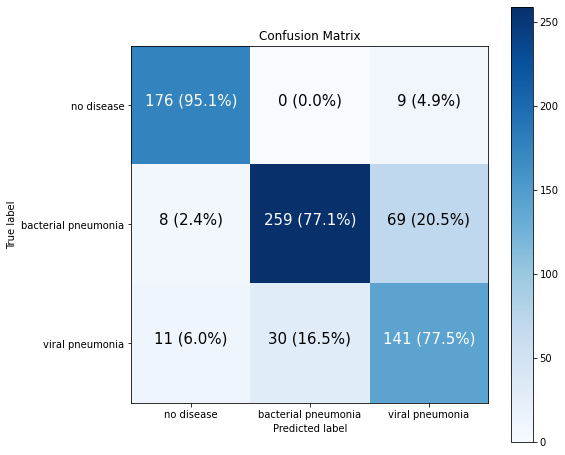

In [45]:
# Make a prettier confusion matrix
make_confusion_matrix(y_true=y_trues, y_pred=y_preds, classes=class_names, figsize=(8,8), text_size=15)

In [ ]:
predictions = model.predict(test_generator) # predict_generator, steps=len(test_dataset)
print(len(predictions))
print(predictions)

In [ ]:
print("Type:",type(predictions))
print("Shape:",predictions.shape)

In [ ]:
preds=[]
for pred in predictions:
    # print(pred)
    y_pred = np.argmax(pred, axis=0)
    preds.append(y_pred)
    # print(y_pred)
print(preds)

In [ ]:
# I have to split images to class folders first!!!!!!!
filenames = test_generator.filenames # list with all filenames # file_paths for Keras
filenames

In [ ]:
lista=[]
for filet in filenames:
    # lista.append(filet.split('/')[-1]) # Google Colab
    lista.append(filet.split('\\')[-1]) # Jupyter
print(lista)

In [ ]:
p=pd.DataFrame(list(zip(lista, preds)),columns=['file_name','class_id'])
p.to_csv('V2B0.csv',index=False)
p

In [98]:
%%time
predictions = model.predict(test_generator)
preds=[]
for pred in predictions:
    y_pred = np.argmax(pred, axis=0)
    preds.append(y_pred)
filenames = test_generator.filenames # list with all filenames # file_paths for Keras
lista=[]
for filet in filenames:
    lista.append(filet.split('\\')[-1]) # Jupyter # lista.append(filet.split('/')[-1]) # Google Colab
p=pd.DataFrame(list(zip(lista, preds)),columns=['file_name','class_id'])
p.to_csv('V2B0.csv',index=False)
p

Wall time: 19.4 s


,file_name,class_id
0,img_1005556732793955351.jpg,0
1,img_1013947992995844467.jpg,2
2,img_1056493789828791097.jpg,1
3,img_1067627733181002215.jpg,2
4,img_1082179150533558647.jpg,0
...,...,...
1163,img_943999834212424978.jpg,0
1164,img_972668160331506727.jpg,1
1165,img_978609420867177867.jpg,2
1166,img_988137790593390154.jpg,1


### EfficientNetB4

In [14]:
IMG_WIDTH = 380
IMG_HEIGHT = 380

In [15]:
# EfficientNetB4
# Model 1: Feature extraction transfer learning on 100% of the data with data augmentation frem Keras (Not as Layer)
# Setup input shape and base model, freezing the base model layers
input_shape = (IMG_WIDTH,IMG_HEIGHT,CHANNELS) # (224, 224, 3)
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB4(include_top=False)
# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# Create input layer
# 3. Create inputs into the base model
inputs = layers.Input(shape=input_shape, name="input_layer")

# # Add in data augmentation Sequential model as a layer
# x = data_augmentation(inputs)
# # Give base_model inputs (after augmentation) and don't train it
# x = base_model(x, training=False)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
# Check data shape after passing it to base_model
# print(f"Shape after base_model: {x.shape}")

# Pool output features of base model
# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
# print(f"After GlobalAveragePooling2D(): {x.shape}")

# Include dropout with probability of 0.2 to avoid overfitting
x = tf.keras.layers.Dropout(.2, seed=seed)(x)
# Add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(128,activation='relu')(x) # dense layer 1
x=Dense(64,activation='relu')(x) # dense layer 2

# Put a dense layer on as the output
# 7. Create the output activation layer
outputs = layers.Dense(CLASSES, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
# 8. Combine the inputs with the outputs into a model
model = keras.Model(inputs, outputs)

# Compile the model
base_learning_rate = 0.0001 # 0.0001

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              metrics=["accuracy"])

print("Base Model:",base_model._name)

Base Model: efficientnetb4


In [16]:
print(len(base_model.trainable_variables))
base_model.summary()

0
Model: "efficientnetb4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_1 (Rescaling)        (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_1 (Normalization  (None, None, None,   7          ['rescaling_1[0][0]']            
 )                              3)                                                 

                                                                                                  
 block2a_expand_conv (Conv2D)   (None, None, None,   3456        ['block1b_add[0][0]']            
                                144)                                                              
                                                                                                  
 block2a_expand_bn (BatchNormal  (None, None, None,   576        ['block2a_expand_conv[0][0]']    
 ization)                       144)                                                              
                                                                                                  
 block2a_expand_activation (Act  (None, None, None,   0          ['block2a_expand_bn[0][0]']      
 ivation)                       144)                                                              
                                                                                                  
 block2a_d

                                192)                                                              
                                                                                                  
 block2c_expand_bn (BatchNormal  (None, None, None,   768        ['block2c_expand_conv[0][0]']    
 ization)                       192)                                                              
                                                                                                  
 block2c_expand_activation (Act  (None, None, None,   0          ['block2c_expand_bn[0][0]']      
 ivation)                       192)                                                              
                                                                                                  
 block2c_dwconv (DepthwiseConv2  (None, None, None,   1728       ['block2c_expand_activation[0][0]
 D)                             192)                             ']                               
          

 block3a_expand_conv (Conv2D)   (None, None, None,   6144        ['block2d_add[0][0]']            
                                192)                                                              
                                                                                                  
 block3a_expand_bn (BatchNormal  (None, None, None,   768        ['block3a_expand_conv[0][0]']    
 ization)                       192)                                                              
                                                                                                  
 block3a_expand_activation (Act  (None, None, None,   0          ['block3a_expand_bn[0][0]']      
 ivation)                       192)                                                              
                                                                                                  
 block3a_dwconv_pad (ZeroPaddin  (None, None, None,   0          ['block3a_expand_activation[0][0]
 g2D)     

                                                                                                  
 block3c_expand_bn (BatchNormal  (None, None, None,   1344       ['block3c_expand_conv[0][0]']    
 ization)                       336)                                                              
                                                                                                  
 block3c_expand_activation (Act  (None, None, None,   0          ['block3c_expand_bn[0][0]']      
 ivation)                       336)                                                              
                                                                                                  
 block3c_dwconv (DepthwiseConv2  (None, None, None,   8400       ['block3c_expand_activation[0][0]
 D)                             336)                             ']                               
                                                                                                  
 block3c_b

                                336)                                                              
                                                                                                  
 block4a_expand_bn (BatchNormal  (None, None, None,   1344       ['block4a_expand_conv[0][0]']    
 ization)                       336)                                                              
                                                                                                  
 block4a_expand_activation (Act  (None, None, None,   0          ['block4a_expand_bn[0][0]']      
 ivation)                       336)                                                              
                                                                                                  
 block4a_dwconv_pad (ZeroPaddin  (None, None, None,   0          ['block4a_expand_activation[0][0]
 g2D)                           336)                             ']                               
          

 block4c_expand_bn (BatchNormal  (None, None, None,   2688       ['block4c_expand_conv[0][0]']    
 ization)                       672)                                                              
                                                                                                  
 block4c_expand_activation (Act  (None, None, None,   0          ['block4c_expand_bn[0][0]']      
 ivation)                       672)                                                              
                                                                                                  
 block4c_dwconv (DepthwiseConv2  (None, None, None,   6048       ['block4c_expand_activation[0][0]
 D)                             672)                             ']                               
                                                                                                  
 block4c_bn (BatchNormalization  (None, None, None,   2688       ['block4c_dwconv[0][0]']         
 )        

                                                                                                  
 block4e_expand_bn (BatchNormal  (None, None, None,   2688       ['block4e_expand_conv[0][0]']    
 ization)                       672)                                                              
                                                                                                  
 block4e_expand_activation (Act  (None, None, None,   0          ['block4e_expand_bn[0][0]']      
 ivation)                       672)                                                              
                                                                                                  
 block4e_dwconv (DepthwiseConv2  (None, None, None,   6048       ['block4e_expand_activation[0][0]
 D)                             672)                             ']                               
                                                                                                  
 block4e_b

                                672)                                                              
                                                                                                  
 block5a_expand_bn (BatchNormal  (None, None, None,   2688       ['block5a_expand_conv[0][0]']    
 ization)                       672)                                                              
                                                                                                  
 block5a_expand_activation (Act  (None, None, None,   0          ['block5a_expand_bn[0][0]']      
 ivation)                       672)                                                              
                                                                                                  
 block5a_dwconv (DepthwiseConv2  (None, None, None,   16800      ['block5a_expand_activation[0][0]
 D)                             672)                             ']                               
          

 block5c_expand_activation (Act  (None, None, None,   0          ['block5c_expand_bn[0][0]']      
 ivation)                       960)                                                              
                                                                                                  
 block5c_dwconv (DepthwiseConv2  (None, None, None,   24000      ['block5c_expand_activation[0][0]
 D)                             960)                             ']                               
                                                                                                  
 block5c_bn (BatchNormalization  (None, None, None,   3840       ['block5c_dwconv[0][0]']         
 )                              960)                                                              
                                                                                                  
 block5c_activation (Activation  (None, None, None,   0          ['block5c_bn[0][0]']             
 )        

                                                                                                  
 block5e_expand_activation (Act  (None, None, None,   0          ['block5e_expand_bn[0][0]']      
 ivation)                       960)                                                              
                                                                                                  
 block5e_dwconv (DepthwiseConv2  (None, None, None,   24000      ['block5e_expand_activation[0][0]
 D)                             960)                             ']                               
                                                                                                  
 block5e_bn (BatchNormalization  (None, None, None,   3840       ['block5e_dwconv[0][0]']         
 )                              960)                                                              
                                                                                                  
 block5e_a

 ization)                       960)                                                              
                                                                                                  
 block6a_expand_activation (Act  (None, None, None,   0          ['block6a_expand_bn[0][0]']      
 ivation)                       960)                                                              
                                                                                                  
 block6a_dwconv_pad (ZeroPaddin  (None, None, None,   0          ['block6a_expand_activation[0][0]
 g2D)                           960)                             ']                               
                                                                                                  
 block6a_dwconv (DepthwiseConv2  (None, None, None,   24000      ['block6a_dwconv_pad[0][0]']     
 D)                             960)                                                              
          

 block6c_expand_activation (Act  (None, None, None,   0          ['block6c_expand_bn[0][0]']      
 ivation)                       1632)                                                             
                                                                                                  
 block6c_dwconv (DepthwiseConv2  (None, None, None,   40800      ['block6c_expand_activation[0][0]
 D)                             1632)                            ']                               
                                                                                                  
 block6c_bn (BatchNormalization  (None, None, None,   6528       ['block6c_dwconv[0][0]']         
 )                              1632)                                                             
                                                                                                  
 block6c_activation (Activation  (None, None, None,   0          ['block6c_bn[0][0]']             
 )        

                                                                                                  
 block6e_expand_activation (Act  (None, None, None,   0          ['block6e_expand_bn[0][0]']      
 ivation)                       1632)                                                             
                                                                                                  
 block6e_dwconv (DepthwiseConv2  (None, None, None,   40800      ['block6e_expand_activation[0][0]
 D)                             1632)                            ']                               
                                                                                                  
 block6e_bn (BatchNormalization  (None, None, None,   6528       ['block6e_dwconv[0][0]']         
 )                              1632)                                                             
                                                                                                  
 block6e_a

 ization)                       1632)                                                             
                                                                                                  
 block6g_expand_activation (Act  (None, None, None,   0          ['block6g_expand_bn[0][0]']      
 ivation)                       1632)                                                             
                                                                                                  
 block6g_dwconv (DepthwiseConv2  (None, None, None,   40800      ['block6g_expand_activation[0][0]
 D)                             1632)                            ']                               
                                                                                                  
 block6g_bn (BatchNormalization  (None, None, None,   6528       ['block6g_dwconv[0][0]']         
 )                              1632)                                                             
          

 block7a_expand_bn (BatchNormal  (None, None, None,   6528       ['block7a_expand_conv[0][0]']    
 ization)                       1632)                                                             
                                                                                                  
 block7a_expand_activation (Act  (None, None, None,   0          ['block7a_expand_bn[0][0]']      
 ivation)                       1632)                                                             
                                                                                                  
 block7a_dwconv (DepthwiseConv2  (None, None, None,   14688      ['block7a_expand_activation[0][0]
 D)                             1632)                            ']                               
                                                                                                  
 block7a_bn (BatchNormalization  (None, None, None,   6528       ['block7a_dwconv[0][0]']         
 )        

                                                                                                  
Total params: 17,673,823
Trainable params: 0
Non-trainable params: 17,673,823
__________________________________________________________________________________________________


In [17]:
print(len(model.trainable_variables))
model.summary() # Check out model summary

6
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 380, 380, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, None, None, 1792)  17673823 
                                                                 
 global_average_pooling_laye  (None, 1792)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 dropout_1 (Dropout)         (None, 1792)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               229504    
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                         

In [18]:
# Check layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 rescaling_1 False
2 normalization_1 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block1b_dwconv False
18 block1b_bn False
19 block1b_activation False
20 block1b_se_squeeze False
21 block1b_se_reshape False
22 block1b_se_reduce False
23 block1b_se_expand False
24 block1b_se_excite False
25 block1b_project_conv False
26 block1b_project_bn False
27 block1b_drop False
28 block1b_add False
29 block2a_expand_conv False
30 block2a_expand_bn False
31 block2a_expand_activation False
32 block2a_dwconv_pad False
33 block2a_dwconv False
34 block2a_bn False
35 block2a_activation False
36 block2a_se_squeeze False
37 block2a_se_reshape False
38 block2a_se_reduce False
39 block2a_s

447 block7a_bn False
448 block7a_activation False
449 block7a_se_squeeze False
450 block7a_se_reshape False
451 block7a_se_reduce False
452 block7a_se_expand False
453 block7a_se_excite False
454 block7a_project_conv False
455 block7a_project_bn False
456 block7b_expand_conv False
457 block7b_expand_bn False
458 block7b_expand_activation False
459 block7b_dwconv False
460 block7b_bn False
461 block7b_activation False
462 block7b_se_squeeze False
463 block7b_se_reshape False
464 block7b_se_reduce False
465 block7b_se_expand False
466 block7b_se_excite False
467 block7b_project_conv False
468 block7b_project_bn False
469 block7b_drop False
470 block7b_add False
471 top_conv False
472 top_bn False
473 top_activation False


In [19]:
%%time
# No fine-tuning!
print("Feature extraction Transfer Learning on",base_model._name,"with ImageNet weights")

earlystop = EarlyStopping(monitor = 'val_accuracy', # 'val_loss', 'val_accuracy' # mode:{"auto", "min", "max"}
                          min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True) 

# Setup checkpoint path  # note: remember saving directly to Colab is temporary
checkpoint_path = "checkpointsB4/basemodelB4-epoch_{epoch:02d}-acc_{val_accuracy:.4f}/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
             save_weights_only=False, # set to False to save the entire model
             save_best_only=False, # set to True to save only the best model instead of a model every epoch 
             save_freq="epoch", # save every epoch
             # monitor='val_acc'
             # mode='auto'                                   
             verbose=0) # 1 --> Epoch 1: saving model to model_checkpoints_weights\checkpoint.ckpt 

import datetime
logdir = os.path.join("logs",base_model._name)
# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logdir,
                                              histogram_freq=1,
                                              write_graph=True,
                                              write_images=False,
                                              # write_steps_per_second=False,
                                              update_freq='epoch',
                                              # profile_batch=2,
                                              # embeddings_metadata=None
                                              embeddings_freq=1)

callbacks = [earlystop, tensorboard] # checkpoint # we put our callbacks into a callback list

STEP_SIZE_TRAIN=train_generator.n // train_generator.batch_size # - 455
STEP_SIZE_VALID=validation_generator.n  // validation_generator.batch_size # - 70
# STEP_SIZE_VALID=test_generator.n  // test_generator.batch_size

# initial_epochs= history.epoch[-1]+1
epochs = 20
# total_epochs = initial_epochs + epochs 
history = model.fit(train_generator, # model.fit_generator is deprecated
                             steps_per_epoch=STEP_SIZE_TRAIN,
                             # initial_epoch=initial_epochs,
                             epochs=epochs, # epochs=total_epochs epochs          
                             validation_data=validation_generator, # validation_split=13.04, test_generator,  
                             validation_steps=STEP_SIZE_VALID,
                             callbacks = callbacks, # add earlystop,  checkpoint & TensorBoard
                             class_weight=class_weights) # Add class weight for imabalanced dataset

print(history.history)

Feature extraction Transfer Learning on efficientnetb4 with ImageNet weights
Epoch 1/20
479/479 [==============================] - 182s 340ms/step - loss: 1.1327 - accuracy: 0.6428 - val_loss: 0.6843 - val_accuracy: 0.6948
Epoch 2/20
479/479 [==============================] - 150s 314ms/step - loss: 0.9113 - accuracy: 0.7122 - val_loss: 0.6405 - val_accuracy: 0.7355
Epoch 3/20
479/479 [==============================] - 151s 314ms/step - loss: 0.8871 - accuracy: 0.7197 - val_loss: 0.6069 - val_accuracy: 0.7442
Epoch 4/20
479/479 [==============================] - 159s 331ms/step - loss: 0.8682 - accuracy: 0.7294 - val_loss: 0.5559 - val_accuracy: 0.7660
Epoch 5/20
479/479 [==============================] - 175s 366ms/step - loss: 0.8419 - accuracy: 0.7417 - val_loss: 0.6412 - val_accuracy: 0.7369
Epoch 6/20
479/479 [==============================] - 158s 329ms/step - loss: 0.8255 - accuracy: 0.7422 - val_loss: 0.5704 - val_accuracy: 0.7674
Epoch 7/20
479/479 [===========================

In [20]:
# Save model and store it to Google Drive
model.save("EfficientNetB4_feature-extraction_TL") # without tuning

INFO:tensorflow:Assets written to: EfficientNetB4_feature-extraction_TL\assets


In [21]:
%%time
print("Fine-Tuning Transfer Learning on",base_model._name,"with previous feature extraction after {} epocks on ImageNet weights".format(history.epoch[-1]+1))
# Unfreeze more & more layers for tuning  --> step by step
# Freeze all layers except for the
unfreeze =  [8,21,36,51,66,81] # list(range(10,100,10)) # [7, 21, 35, 49, 63, 77, 91, 105]
for f in unfreeze:
    base_model.trainable = True
    for layer in base_model.layers[:-f]: # unfreeze last f layers [10, 20, 30, 40, 50, 60, 70, 80, 90]
        layer.trainable = False

    # Recompile the model (always recompile after any adjustments to a model)
    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                  metrics=["accuracy"])

    # Setup checkpoint path
    checkpoint_path = "checkpoints_B4/fine-tuning-unfreeze_{}".format(f)
    print("fine-tuning unfreeze {}".format(f))
    checkpoint_path = checkpoint_path + "-epoch_{epoch:02d}-acc_{val_accuracy:.4f}/checkpoint.ckpt"
    # print(checkpoint_path)
    
    # Create a ModelCheckpoint callback that saves the model's weights only
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                 save_weights_only=False, # set to False to save the entire model
                 save_best_only=False, # set to True to save only the best model instead of a model every epoch 
                 save_freq="epoch", # save every epoch
                 # monitor='val_acc'
                 # mode='auto'                                    
                 verbose=0) # 1 --> Epoch 1: saving model to model_checkpoints_weights\checkpoint.ckpt 
    
    earlystop = EarlyStopping(monitor = 'val_accuracy', # 'val_loss', 'val_accuracy' # mode:{"auto", "min", "max"}
                              min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True) # patience=10
    import datetime
    logdir = os.path.join("logs",base_model._name)
    # logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logdir,
                                                  histogram_freq=1,
                                                  write_graph=True,
                                                  write_images=False,
                                                  # write_steps_per_second=False,
                                                  update_freq='epoch',
                                                  # profile_batch=2,
                                                  # embeddings_metadata=None
                                                  embeddings_freq=1)

    callbacks = [earlystop, tensorboard] # checkpoint # we put our call backs into a callback list

    STEP_SIZE_TRAIN=train_generator.n // train_generator.batch_size
    STEP_SIZE_VALID=validation_generator.n  // validation_generator.batch_size
    # STEP_SIZE_VALID=test_generator.n  // test_generator.batch_size
    
    initial_epochs= history.epoch[-1]+1                
    epochs = 20 # 10 or 15 or 20
    total_epochs = initial_epochs + epochs                
    # Refit the model (same as model except with more trainable layers)
    history = model.fit(train_generator, # model.fit_generator is deprecated
                                 steps_per_epoch=STEP_SIZE_TRAIN,
                                 initial_epoch=initial_epochs,
                                 epochs=total_epochs,
                                 # epochs=epochs,
                                 validation_data=validation_generator, # test_generator,  validation_generator
                                 validation_steps=STEP_SIZE_VALID,
                                 callbacks = callbacks, # add earlystop
                                 class_weight=class_weights) # Add class weight for imabalanced dataset
    
    print(history.history)
    # print(model.evaluate(test_generator))

# Save model and store it to Google Drive
model.save("EfficientNetB4_fine-tuning_TL_non-stop") # with tuning

# saved_model_results = model.evaluate(test_generator)
# print(saved_model_results)

Fine-Tuning Transfer Learning on efficientnetb4 with previous feature extraction after 20 epocks on ImageNet weights
fine-tuning unfreeze 8
Epoch 21/40
479/479 [==============================] - 168s 324ms/step - loss: 0.8369 - accuracy: 0.7476 - val_loss: 0.5441 - val_accuracy: 0.7718
Epoch 22/40
479/479 [==============================] - 156s 325ms/step - loss: 0.7791 - accuracy: 0.7617 - val_loss: 0.5289 - val_accuracy: 0.7834
Epoch 23/40
479/479 [==============================] - 157s 327ms/step - loss: 0.7524 - accuracy: 0.7735 - val_loss: 0.5582 - val_accuracy: 0.7616
Epoch 24/40
479/479 [==============================] - 156s 326ms/step - loss: 0.7432 - accuracy: 0.7703 - val_loss: 0.5181 - val_accuracy: 0.7892
Epoch 25/40
479/479 [==============================] - 158s 330ms/step - loss: 0.7255 - accuracy: 0.7741 - val_loss: 0.5555 - val_accuracy: 0.7820
Epoch 26/40
479/479 [==============================] - 159s 331ms/step - loss: 0.7191 - accuracy: 0.7786 - val_loss: 0.5044 -

479/479 [==============================] - 177s 340ms/step - loss: 0.6584 - accuracy: 0.7984 - val_loss: 0.4960 - val_accuracy: 0.8081
Epoch 56/74
479/479 [==============================] - 161s 335ms/step - loss: 0.5882 - accuracy: 0.8143 - val_loss: 0.5120 - val_accuracy: 0.7922
Epoch 57/74
479/479 [==============================] - 162s 338ms/step - loss: 0.5801 - accuracy: 0.8200 - val_loss: 0.4599 - val_accuracy: 0.8169
Epoch 58/74
479/479 [==============================] - 162s 337ms/step - loss: 0.5570 - accuracy: 0.8242 - val_loss: 0.5361 - val_accuracy: 0.7951
Epoch 59/74
479/479 [==============================] - 167s 348ms/step - loss: 0.5275 - accuracy: 0.8352 - val_loss: 0.4938 - val_accuracy: 0.8241
Epoch 60/74
479/479 [==============================] - 161s 336ms/step - loss: 0.5096 - accuracy: 0.8358 - val_loss: 0.5670 - val_accuracy: 0.7660
Epoch 61/74
479/479 [==============================] - 161s 336ms/step - loss: 0.4930 - accuracy: 0.8481 - val_loss: 0.5468 - val_

Epoch 90/109
479/479 [==============================] - 181s 348ms/step - loss: 0.2909 - accuracy: 0.9135 - val_loss: 0.5456 - val_accuracy: 0.8299
Epoch 91/109
479/479 [==============================] - 164s 342ms/step - loss: 0.2645 - accuracy: 0.9202 - val_loss: 0.5733 - val_accuracy: 0.8125
Epoch 92/109
479/479 [==============================] - 167s 347ms/step - loss: 0.2793 - accuracy: 0.9207 - val_loss: 0.5462 - val_accuracy: 0.8358
Epoch 93/109
479/479 [==============================] - 162s 338ms/step - loss: 0.2511 - accuracy: 0.9250 - val_loss: 0.6398 - val_accuracy: 0.8169
Epoch 94/109
479/479 [==============================] - 163s 339ms/step - loss: 0.2430 - accuracy: 0.9269 - val_loss: 0.6650 - val_accuracy: 0.8256
Epoch 95/109
479/479 [==============================] - 162s 338ms/step - loss: 0.2463 - accuracy: 0.9280 - val_loss: 0.6071 - val_accuracy: 0.8227
Epoch 96/109
479/479 [==============================] - 162s 338ms/step - loss: 0.2346 - accuracy: 0.9318 - val_

In [46]:
model= tf.keras.models.load_model("EfficientNetB4_fine-tuning_TL_non-stop")
display(model.summary())
display(model.evaluate(train_generator))
display(model.evaluate(validation_generator))
# Prediction/Submition

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 380, 380, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, None, None, 1792)  17673823 
                                                                 
 global_average_pooling_laye  (None, 1792)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 dropout_1 (Dropout)         (None, 1792)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               229504    
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                           

None

In [60]:
%%time
IMG_WIDTH = 380
IMG_HEIGHT = 380
# Confution Matrix and Classification Report
y_preds, y_trues = [],[]
for i in range(len(validation_generator)): # len = 11
    # Get a sample of the validation data batch 
    images, labels = validation_generator.next() # get the 'next' batch=16 of images/labels
    for i in range(len(labels)):
        Y_pred = model.predict(images[i].reshape((1,) + images[i].shape)) # , batch_size = 1
        y_pred = np.argmax(Y_pred, axis=1) # y_classes = keras.np_utils.probas_to_classes(y_proba)
        y_preds.append(y_pred[0])
        y_trues.append(np.argmax(labels[i], axis=0)) # categorical (array)
print('Confusion Matrix')
print(confusion_matrix(y_trues, y_preds))
print('Classification Report')
print(classification_report(y_trues, y_preds, target_names=class_names))

Confusion Matrix
[[170   8   7]
 [  5 296  35]
 [  6  74 102]]
Classification Report
                     precision    recall  f1-score   support

         no disease       0.94      0.92      0.93       185
bacterial pneumonia       0.78      0.88      0.83       336
    viral pneumonia       0.71      0.56      0.63       182

           accuracy                           0.81       703
          macro avg       0.81      0.79      0.79       703
       weighted avg       0.80      0.81      0.80       703

Wall time: 1min 14s


In [100]:
%%time
predictions = model.predict(test_generator)
preds=[]
for pred in predictions:
    y_pred = np.argmax(pred, axis=0)
    preds.append(y_pred)
filenames = test_generator.filenames # list with all filenames # file_paths for Keras
lista=[]
for filet in filenames:
    lista.append(filet.split('\\')[-1]) # Jupyter # lista.append(filet.split('/')[-1]) # Google Colab
p=pd.DataFrame(list(zip(lista, preds)),columns=['file_name','class_id'])
p.to_csv('B4.csv',index=False)
p

Wall time: 38.6 s


,file_name,class_id
0,img_1005556732793955351.jpg,0
1,img_1013947992995844467.jpg,2
2,img_1056493789828791097.jpg,1
3,img_1067627733181002215.jpg,2
4,img_1082179150533558647.jpg,0
...,...,...
1163,img_943999834212424978.jpg,0
1164,img_972668160331506727.jpg,1
1165,img_978609420867177867.jpg,2
1166,img_988137790593390154.jpg,1


### EfficientNetB7

In [117]:
IMG_WIDTH = 600
IMG_HEIGHT = 600

In [29]:
# EfficientNetB7
# Model 1: Feature extraction transfer learning on 100% of the data with data augmentation frem Keras (Not as Layer)
# Setup input shape and base model, freezing the base model layers
input_shape = (IMG_WIDTH,IMG_HEIGHT,CHANNELS) # (224, 224, 3)
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB7(include_top=False)
# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# Create input layer
# 3. Create inputs into the base model
inputs = layers.Input(shape=input_shape, name="input_layer")

# # Add in data augmentation Sequential model as a layer
# x = data_augmentation(inputs)
# # Give base_model inputs (after augmentation) and don't train it
# x = base_model(x, training=False)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
# Check data shape after passing it to base_model
# print(f"Shape after base_model: {x.shape}")

# Pool output features of base model
# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
# print(f"After GlobalAveragePooling2D(): {x.shape}")

# Include dropout with probability of 0.2 to avoid overfitting
x = tf.keras.layers.Dropout(.2, seed=seed)(x)
# Add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(128,activation='relu')(x) # dense layer 1
x=Dense(64,activation='relu')(x) # dense layer 2

# Put a dense layer on as the output
# 7. Create the output activation layer
outputs = layers.Dense(CLASSES, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
# 8. Combine the inputs with the outputs into a model
model = keras.Model(inputs, outputs)

# Compile the model
base_learning_rate = 0.0001 # 0.0001

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              metrics=["accuracy"])

print("Base Model:",base_model._name)

Base Model: efficientnetb7


In [30]:
print(len(base_model.trainable_variables))
base_model.summary()

0
Model: "efficientnetb7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                 

                                                                                                  
 block1c_dwconv (DepthwiseConv2  (None, None, None,   288        ['block1b_add[0][0]']            
 D)                             32)                                                               
                                                                                                  
 block1c_bn (BatchNormalization  (None, None, None,   128        ['block1c_dwconv[0][0]']         
 )                              32)                                                               
                                                                                                  
 block1c_activation (Activation  (None, None, None,   0          ['block1c_bn[0][0]']             
 )                              32)                                                               
                                                                                                  
 block1c_s

 )                              192)                                                              
                                                                                                  
 block2a_activation (Activation  (None, None, None,   0          ['block2a_bn[0][0]']             
 )                              192)                                                              
                                                                                                  
 block2a_se_squeeze (GlobalAver  (None, 192)         0           ['block2a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2a_se_reshape (Reshape)   (None, 1, 1, 192)    0           ['block2a_se_squeeze[0][0]']     
                                                                                                  
 block2a_s

 block2c_se_squeeze (GlobalAver  (None, 288)         0           ['block2c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2c_se_reshape (Reshape)   (None, 1, 1, 288)    0           ['block2c_se_squeeze[0][0]']     
                                                                                                  
 block2c_se_reduce (Conv2D)     (None, 1, 1, 12)     3468        ['block2c_se_reshape[0][0]']     
                                                                                                  
 block2c_se_expand (Conv2D)     (None, 1, 1, 288)    3744        ['block2c_se_reduce[0][0]']      
                                                                                                  
 block2c_se_excite (Multiply)   (None, None, None,   0           ['block2c_activation[0][0]',     
          

                                                                                                  
 block2e_se_squeeze (GlobalAver  (None, 288)         0           ['block2e_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2e_se_reshape (Reshape)   (None, 1, 1, 288)    0           ['block2e_se_squeeze[0][0]']     
                                                                                                  
 block2e_se_reduce (Conv2D)     (None, 1, 1, 12)     3468        ['block2e_se_reshape[0][0]']     
                                                                                                  
 block2e_se_expand (Conv2D)     (None, 1, 1, 288)    3744        ['block2e_se_reduce[0][0]']      
                                                                                                  
 block2e_s

 )                              288)                                                              
                                                                                                  
 block2g_se_squeeze (GlobalAver  (None, 288)         0           ['block2g_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2g_se_reshape (Reshape)   (None, 1, 1, 288)    0           ['block2g_se_squeeze[0][0]']     
                                                                                                  
 block2g_se_reduce (Conv2D)     (None, 1, 1, 12)     3468        ['block2g_se_reshape[0][0]']     
                                                                                                  
 block2g_se_expand (Conv2D)     (None, 1, 1, 288)    3744        ['block2g_se_reduce[0][0]']      
          

 block3b_se_squeeze (GlobalAver  (None, 480)         0           ['block3b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3b_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block3b_se_squeeze[0][0]']     
                                                                                                  
 block3b_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block3b_se_reshape[0][0]']     
                                                                                                  
 block3b_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block3b_se_reduce[0][0]']      
                                                                                                  
 block3b_se_excite (Multiply)   (None, None, None,   0           ['block3b_activation[0][0]',     
          

                                                                                                  
 block3d_se_squeeze (GlobalAver  (None, 480)         0           ['block3d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3d_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block3d_se_squeeze[0][0]']     
                                                                                                  
 block3d_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block3d_se_reshape[0][0]']     
                                                                                                  
 block3d_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block3d_se_reduce[0][0]']      
                                                                                                  
 block3d_s

 )                              480)                                                              
                                                                                                  
 block3f_se_squeeze (GlobalAver  (None, 480)         0           ['block3f_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3f_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block3f_se_squeeze[0][0]']     
                                                                                                  
 block3f_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block3f_se_reshape[0][0]']     
                                                                                                  
 block3f_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block3f_se_reduce[0][0]']      
          

 block4a_bn (BatchNormalization  (None, None, None,   1920       ['block4a_dwconv[0][0]']         
 )                              480)                                                              
                                                                                                  
 block4a_activation (Activation  (None, None, None,   0          ['block4a_bn[0][0]']             
 )                              480)                                                              
                                                                                                  
 block4a_se_squeeze (GlobalAver  (None, 480)         0           ['block4a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block4a_se_squeeze[0][0]']     
          

                                                                                                  
 block4c_se_squeeze (GlobalAver  (None, 960)         0           ['block4c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4c_se_reshape (Reshape)   (None, 1, 1, 960)    0           ['block4c_se_squeeze[0][0]']     
                                                                                                  
 block4c_se_reduce (Conv2D)     (None, 1, 1, 40)     38440       ['block4c_se_reshape[0][0]']     
                                                                                                  
 block4c_se_expand (Conv2D)     (None, 1, 1, 960)    39360       ['block4c_se_reduce[0][0]']      
                                                                                                  
 block4c_s

 )                              960)                                                              
                                                                                                  
 block4e_se_squeeze (GlobalAver  (None, 960)         0           ['block4e_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4e_se_reshape (Reshape)   (None, 1, 1, 960)    0           ['block4e_se_squeeze[0][0]']     
                                                                                                  
 block4e_se_reduce (Conv2D)     (None, 1, 1, 40)     38440       ['block4e_se_reshape[0][0]']     
                                                                                                  
 block4e_se_expand (Conv2D)     (None, 1, 1, 960)    39360       ['block4e_se_reduce[0][0]']      
          

 block4g_activation (Activation  (None, None, None,   0          ['block4g_bn[0][0]']             
 )                              960)                                                              
                                                                                                  
 block4g_se_squeeze (GlobalAver  (None, 960)         0           ['block4g_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4g_se_reshape (Reshape)   (None, 1, 1, 960)    0           ['block4g_se_squeeze[0][0]']     
                                                                                                  
 block4g_se_reduce (Conv2D)     (None, 1, 1, 40)     38440       ['block4g_se_reshape[0][0]']     
                                                                                                  
 block4g_s

                                                                                                  
 block4i_activation (Activation  (None, None, None,   0          ['block4i_bn[0][0]']             
 )                              960)                                                              
                                                                                                  
 block4i_se_squeeze (GlobalAver  (None, 960)         0           ['block4i_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4i_se_reshape (Reshape)   (None, 1, 1, 960)    0           ['block4i_se_squeeze[0][0]']     
                                                                                                  
 block4i_se_reduce (Conv2D)     (None, 1, 1, 40)     38440       ['block4i_se_reshape[0][0]']     
          

 )                              960)                                                              
                                                                                                  
 block5a_activation (Activation  (None, None, None,   0          ['block5a_bn[0][0]']             
 )                              960)                                                              
                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 960)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 960)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_s

 block5c_se_squeeze (GlobalAver  (None, 1344)        0           ['block5c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5c_se_reshape (Reshape)   (None, 1, 1, 1344)   0           ['block5c_se_squeeze[0][0]']     
                                                                                                  
 block5c_se_reduce (Conv2D)     (None, 1, 1, 56)     75320       ['block5c_se_reshape[0][0]']     
                                                                                                  
 block5c_se_expand (Conv2D)     (None, 1, 1, 1344)   76608       ['block5c_se_reduce[0][0]']      
                                                                                                  
 block5c_se_excite (Multiply)   (None, None, None,   0           ['block5c_activation[0][0]',     
          

                                                                                                  
 block5e_se_squeeze (GlobalAver  (None, 1344)        0           ['block5e_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5e_se_reshape (Reshape)   (None, 1, 1, 1344)   0           ['block5e_se_squeeze[0][0]']     
                                                                                                  
 block5e_se_reduce (Conv2D)     (None, 1, 1, 56)     75320       ['block5e_se_reshape[0][0]']     
                                                                                                  
 block5e_se_expand (Conv2D)     (None, 1, 1, 1344)   76608       ['block5e_se_reduce[0][0]']      
                                                                                                  
 block5e_s

 )                              1344)                                                             
                                                                                                  
 block5g_se_squeeze (GlobalAver  (None, 1344)        0           ['block5g_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5g_se_reshape (Reshape)   (None, 1, 1, 1344)   0           ['block5g_se_squeeze[0][0]']     
                                                                                                  
 block5g_se_reduce (Conv2D)     (None, 1, 1, 56)     75320       ['block5g_se_reshape[0][0]']     
                                                                                                  
 block5g_se_expand (Conv2D)     (None, 1, 1, 1344)   76608       ['block5g_se_reduce[0][0]']      
          

 block5i_activation (Activation  (None, None, None,   0          ['block5i_bn[0][0]']             
 )                              1344)                                                             
                                                                                                  
 block5i_se_squeeze (GlobalAver  (None, 1344)        0           ['block5i_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5i_se_reshape (Reshape)   (None, 1, 1, 1344)   0           ['block5i_se_squeeze[0][0]']     
                                                                                                  
 block5i_se_reduce (Conv2D)     (None, 1, 1, 56)     75320       ['block5i_se_reshape[0][0]']     
                                                                                                  
 block5i_s

                                                                                                  
 block6a_bn (BatchNormalization  (None, None, None,   5376       ['block6a_dwconv[0][0]']         
 )                              1344)                                                             
                                                                                                  
 block6a_activation (Activation  (None, None, None,   0          ['block6a_bn[0][0]']             
 )                              1344)                                                             
                                                                                                  
 block6a_se_squeeze (GlobalAver  (None, 1344)        0           ['block6a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6a_s

 )                              2304)                                                             
                                                                                                  
 block6c_se_squeeze (GlobalAver  (None, 2304)        0           ['block6c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6c_se_reshape (Reshape)   (None, 1, 1, 2304)   0           ['block6c_se_squeeze[0][0]']     
                                                                                                  
 block6c_se_reduce (Conv2D)     (None, 1, 1, 96)     221280      ['block6c_se_reshape[0][0]']     
                                                                                                  
 block6c_se_expand (Conv2D)     (None, 1, 1, 2304)   223488      ['block6c_se_reduce[0][0]']      
          

 block6e_activation (Activation  (None, None, None,   0          ['block6e_bn[0][0]']             
 )                              2304)                                                             
                                                                                                  
 block6e_se_squeeze (GlobalAver  (None, 2304)        0           ['block6e_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6e_se_reshape (Reshape)   (None, 1, 1, 2304)   0           ['block6e_se_squeeze[0][0]']     
                                                                                                  
 block6e_se_reduce (Conv2D)     (None, 1, 1, 96)     221280      ['block6e_se_reshape[0][0]']     
                                                                                                  
 block6e_s

                                                                                                  
 block6g_activation (Activation  (None, None, None,   0          ['block6g_bn[0][0]']             
 )                              2304)                                                             
                                                                                                  
 block6g_se_squeeze (GlobalAver  (None, 2304)        0           ['block6g_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6g_se_reshape (Reshape)   (None, 1, 1, 2304)   0           ['block6g_se_squeeze[0][0]']     
                                                                                                  
 block6g_se_reduce (Conv2D)     (None, 1, 1, 96)     221280      ['block6g_se_reshape[0][0]']     
          

 )                              2304)                                                             
                                                                                                  
 block6i_activation (Activation  (None, None, None,   0          ['block6i_bn[0][0]']             
 )                              2304)                                                             
                                                                                                  
 block6i_se_squeeze (GlobalAver  (None, 2304)        0           ['block6i_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6i_se_reshape (Reshape)   (None, 1, 1, 2304)   0           ['block6i_se_squeeze[0][0]']     
                                                                                                  
 block6i_s

 block6k_bn (BatchNormalization  (None, None, None,   9216       ['block6k_dwconv[0][0]']         
 )                              2304)                                                             
                                                                                                  
 block6k_activation (Activation  (None, None, None,   0          ['block6k_bn[0][0]']             
 )                              2304)                                                             
                                                                                                  
 block6k_se_squeeze (GlobalAver  (None, 2304)        0           ['block6k_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6k_se_reshape (Reshape)   (None, 1, 1, 2304)   0           ['block6k_se_squeeze[0][0]']     
          

                                                                                                  
 block6m_bn (BatchNormalization  (None, None, None,   9216       ['block6m_dwconv[0][0]']         
 )                              2304)                                                             
                                                                                                  
 block6m_activation (Activation  (None, None, None,   0          ['block6m_bn[0][0]']             
 )                              2304)                                                             
                                                                                                  
 block6m_se_squeeze (GlobalAver  (None, 2304)        0           ['block6m_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6m_s

 )                              3840)                                                             
                                                                                                  
 block7b_se_squeeze (GlobalAver  (None, 3840)        0           ['block7b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block7b_se_reshape (Reshape)   (None, 1, 1, 3840)   0           ['block7b_se_squeeze[0][0]']     
                                                                                                  
 block7b_se_reduce (Conv2D)     (None, 1, 1, 160)    614560      ['block7b_se_reshape[0][0]']     
                                                                                                  
 block7b_se_expand (Conv2D)     (None, 1, 1, 3840)   618240      ['block7b_se_reduce[0][0]']      
          

 block7d_activation (Activation  (None, None, None,   0          ['block7d_bn[0][0]']             
 )                              3840)                                                             
                                                                                                  
 block7d_se_squeeze (GlobalAver  (None, 3840)        0           ['block7d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block7d_se_reshape (Reshape)   (None, 1, 1, 3840)   0           ['block7d_se_squeeze[0][0]']     
                                                                                                  
 block7d_se_reduce (Conv2D)     (None, 1, 1, 160)    614560      ['block7d_se_reshape[0][0]']     
                                                                                                  
 block7d_s

In [31]:
print(len(model.trainable_variables))
model.summary() # Check out model summary

6
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 600, 600, 3)]     0         
                                                                 
 efficientnetb7 (Functional)  (None, None, None, 2560)  64097687 
                                                                 
 global_average_pooling_laye  (None, 2560)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 dropout (Dropout)           (None, 2560)              0         
                                                                 
 dense (Dense)               (None, 128)               327808    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                           

In [32]:
# Check layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block1b_dwconv False
18 block1b_bn False
19 block1b_activation False
20 block1b_se_squeeze False
21 block1b_se_reshape False
22 block1b_se_reduce False
23 block1b_se_expand False
24 block1b_se_excite False
25 block1b_project_conv False
26 block1b_project_bn False
27 block1b_drop False
28 block1b_add False
29 block1c_dwconv False
30 block1c_bn False
31 block1c_activation False
32 block1c_se_squeeze False
33 block1c_se_reshape False
34 block1c_se_reduce False
35 block1c_se_expand False
36 block1c_se_excite False
37 block1c_project_conv False
38 block1c_project_bn False
39 block1c_drop False
4

In [27]:
%%time
# No fine-tuning!
print("Feature extraction Transfer Learning on",base_model._name,"with ImageNet weights")

earlystop = EarlyStopping(monitor = 'val_accuracy', # 'val_loss', 'val_accuracy' # mode:{"auto", "min", "max"}
                          min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True) 

# Setup checkpoint path  # note: remember saving directly to Colab is temporary
checkpoint_path = "checkpointsB7/basemodelB7-epoch_{epoch:02d}-acc_{val_accuracy:.4f}/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
             save_weights_only=False, # set to False to save the entire model
             save_best_only=False, # set to True to save only the best model instead of a model every epoch 
             save_freq="epoch", # save every epoch
             # monitor='val_acc'
             # mode='auto'                                   
             verbose=0) # 1 --> Epoch 1: saving model to model_checkpoints_weights\checkpoint.ckpt 

import datetime
logdir = os.path.join("logs",base_model._name)
# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logdir,
                                              histogram_freq=1,
                                              write_graph=True,
                                              write_images=False,
                                              # write_steps_per_second=False,
                                              update_freq='epoch',
                                              # profile_batch=2,
                                              # embeddings_metadata=None
                                              embeddings_freq=1)

callbacks = [earlystop, tensorboard] # checkpoint # we put our callbacks into a callback list

STEP_SIZE_TRAIN=train_generator.n // train_generator.batch_size # - 455
STEP_SIZE_VALID=validation_generator.n  // validation_generator.batch_size # - 70
# STEP_SIZE_VALID=test_generator.n  // test_generator.batch_size

# initial_epochs= history.epoch[-1]+1
epochs = 20
# total_epochs = initial_epochs + epochs 
history = model.fit(train_generator, # model.fit_generator is deprecated
                             steps_per_epoch=STEP_SIZE_TRAIN,
                             # initial_epoch=initial_epochs,
                             epochs=epochs, # epochs=total_epochs epochs          
                             validation_data=validation_generator, # validation_split=13.04, test_generator,  
                             validation_steps=STEP_SIZE_VALID,
                             callbacks = callbacks, # add earlystop,  checkpoint & TensorBoard
                             class_weight=class_weights) # Add class weight for imabalanced dataset

print(history.history)

Feature extraction Transfer Learning on efficientnetb7 with ImageNet weights
Epoch 1/20
479/479 [==============================] - 203s 373ms/step - loss: 1.1137 - accuracy: 0.6372 - val_loss: 0.6773 - val_accuracy: 0.7137
Epoch 2/20
479/479 [==============================] - 182s 379ms/step - loss: 0.9074 - accuracy: 0.7189 - val_loss: 0.6457 - val_accuracy: 0.7340
Epoch 3/20
479/479 [==============================] - 188s 392ms/step - loss: 0.8682 - accuracy: 0.7362 - val_loss: 0.5890 - val_accuracy: 0.7660
Epoch 4/20
479/479 [==============================] - 182s 380ms/step - loss: 0.8558 - accuracy: 0.7384 - val_loss: 0.5310 - val_accuracy: 0.7951
Epoch 5/20
479/479 [==============================] - 187s 390ms/step - loss: 0.8338 - accuracy: 0.7483 - val_loss: 0.5405 - val_accuracy: 0.7820
Epoch 6/20
479/479 [==============================] - 184s 382ms/step - loss: 0.8233 - accuracy: 0.7474 - val_loss: 0.5253 - val_accuracy: 0.7907
Epoch 7/20
479/479 [===========================

In [31]:
# Save model and store it to Google Drive
model.save("EfficientNetB4_fine-tuning_TL_non-stop_new") # with tuning

INFO:tensorflow:Assets written to: EfficientNetB4_fine-tuning_TL_non-stop_new\assets


In [29]:
%%time
print("Fine-Tuning Transfer Learning on",base_model._name,"with previous feature extraction after {} epocks on ImageNet weights".format(history.epoch[-1]+1))
# Unfreeze more & more layers for tuning  --> step by step
# Freeze all layers except for the
unfreeze =  [8,21,36,51,66,81] # list(range(10,100,10)) # [7, 21, 35, 49, 63, 77, 91, 105]
for f in unfreeze:
    base_model.trainable = True
    for layer in base_model.layers[:-f]: # unfreeze last f layers [10, 20, 30, 40, 50, 60, 70, 80, 90]
        layer.trainable = False

    # Recompile the model (always recompile after any adjustments to a model)
    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                  metrics=["accuracy"])

    # Setup checkpoint path
    checkpoint_path = "checkpoints_B7/fine-tuning-unfreeze_{}".format(f)
    print("fine-tuning unfreeze {}".format(f))
    checkpoint_path = checkpoint_path + "-epoch_{epoch:02d}-acc_{val_accuracy:.4f}/checkpoint.ckpt"
    # print(checkpoint_path)
    
    # Create a ModelCheckpoint callback that saves the model's weights only
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                 save_weights_only=False, # set to False to save the entire model
                 save_best_only=False, # set to True to save only the best model instead of a model every epoch 
                 save_freq="epoch", # save every epoch
                 # monitor='val_acc'
                 # mode='auto'                                    
                 verbose=0) # 1 --> Epoch 1: saving model to model_checkpoints_weights\checkpoint.ckpt 
    
    earlystop = EarlyStopping(monitor = 'val_accuracy', # 'val_loss', 'val_accuracy' # mode:{"auto", "min", "max"}
                              min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True) # patience=10
    import datetime
    logdir = os.path.join("logs",base_model._name)
    # logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logdir,
                                                  histogram_freq=1,
                                                  write_graph=True,
                                                  write_images=False,
                                                  # write_steps_per_second=False,
                                                  update_freq='epoch',
                                                  # profile_batch=2,
                                                  # embeddings_metadata=None
                                                  embeddings_freq=1)

    callbacks = [earlystop, tensorboard] # checkpoint # we put our call backs into a callback list

    STEP_SIZE_TRAIN=train_generator.n // train_generator.batch_size
    STEP_SIZE_VALID=validation_generator.n  // validation_generator.batch_size
    # STEP_SIZE_VALID=test_generator.n  // test_generator.batch_size
    
    initial_epochs= history.epoch[-1]+1                
    epochs = 20 # 10 or 15 or 20
    total_epochs = initial_epochs + epochs                
    # Refit the model (same as model except with more trainable layers)
    history = model.fit(train_generator, # model.fit_generator is deprecated
                                 steps_per_epoch=STEP_SIZE_TRAIN,
                                 initial_epoch=initial_epochs,
                                 epochs=total_epochs,
                                 # epochs=epochs,
                                 validation_data=validation_generator, # test_generator,  validation_generator
                                 validation_steps=STEP_SIZE_VALID,
                                 callbacks = callbacks, # add earlystop
                                 class_weight=class_weights) # Add class weight for imabalanced dataset
    
    print(history.history)
    # print(model.evaluate(test_generator))

# Save model and store it to Google Drive
model.save("EfficientNetB7_fine-tuning_TL_non-stop") # with tuning

# saved_model_results = model.evaluate(test_generator)
# print(saved_model_results

Fine-Tuning Transfer Learning on efficientnetb7 with previous feature extraction after 14 epocks on ImageNet weights
fine-tuning unfreeze 8
Epoch 15/34
479/479 [==============================] - 239s 446ms/step - loss: 0.8955 - accuracy: 0.7302 - val_loss: 0.5542 - val_accuracy: 0.7776
Epoch 16/34
479/479 [==============================] - 214s 446ms/step - loss: 0.8007 - accuracy: 0.7512 - val_loss: 0.5627 - val_accuracy: 0.7747
Epoch 17/34
479/479 [==============================] - 216s 450ms/step - loss: 0.7853 - accuracy: 0.7554 - val_loss: 0.5338 - val_accuracy: 0.7689
Epoch 18/34
479/479 [==============================] - 217s 453ms/step - loss: 0.7437 - accuracy: 0.7701 - val_loss: 0.6698 - val_accuracy: 0.7224
Epoch 19/34
479/479 [==============================] - 219s 456ms/step - loss: 0.7311 - accuracy: 0.7769 - val_loss: 0.6064 - val_accuracy: 0.7529
Epoch 20/34
479/479 [==============================] - 217s 453ms/step - loss: 0.7149 - accuracy: 0.7745 - val_loss: 0.6189 -

Epoch 55/74
479/479 [==============================] - 240s 449ms/step - loss: 0.5508 - accuracy: 0.8314 - val_loss: 0.5771 - val_accuracy: 0.7529
Epoch 56/74
479/479 [==============================] - 211s 440ms/step - loss: 0.5021 - accuracy: 0.8411 - val_loss: 0.4692 - val_accuracy: 0.8081
Epoch 57/74
479/479 [==============================] - 210s 438ms/step - loss: 0.4779 - accuracy: 0.8510 - val_loss: 0.4825 - val_accuracy: 0.7776
Epoch 58/74
479/479 [==============================] - 210s 438ms/step - loss: 0.4711 - accuracy: 0.8522 - val_loss: 0.6442 - val_accuracy: 0.7544
Epoch 59/74
479/479 [==============================] - 210s 437ms/step - loss: 0.4627 - accuracy: 0.8526 - val_loss: 0.4841 - val_accuracy: 0.7994
Epoch 60/74
479/479 [==============================] - 214s 445ms/step - loss: 0.4687 - accuracy: 0.8495 - val_loss: 0.4865 - val_accuracy: 0.7965
Epoch 61/74
479/479 [==============================] - 214s 446ms/step - loss: 0.4444 - accuracy: 0.8623 - val_loss: 0

Epoch 90/108
479/479 [==============================] - 223s 464ms/step - loss: 0.4574 - accuracy: 0.8549 - val_loss: 0.5209 - val_accuracy: 0.8052
Epoch 91/108
479/479 [==============================] - 221s 459ms/step - loss: 0.4298 - accuracy: 0.8674 - val_loss: 0.5506 - val_accuracy: 0.8052
Epoch 92/108
479/479 [==============================] - 224s 467ms/step - loss: 0.3999 - accuracy: 0.8797 - val_loss: 0.6345 - val_accuracy: 0.7965
Epoch 93/108
479/479 [==============================] - 221s 460ms/step - loss: 0.3899 - accuracy: 0.8830 - val_loss: 0.6587 - val_accuracy: 0.7776
Epoch 94/108
479/479 [==============================] - 225s 468ms/step - loss: 0.3658 - accuracy: 0.8870 - val_loss: 0.5523 - val_accuracy: 0.8125
Epoch 95/108
479/479 [==============================] - 222s 462ms/step - loss: 0.3469 - accuracy: 0.8911 - val_loss: 0.5606 - val_accuracy: 0.8096
Epoch 96/108
479/479 [==============================] - 217s 452ms/step - loss: 0.3303 - accuracy: 0.8983 - val_

UnknownError: Failed to WriteFile: logs\efficientnetb7\train\keras_embedding.ckpt-120_temp/part-00000-of-00001.data-00000-of-00001.tempstate2992744342930868402 : Δεν υπάρχει αρκετός χώρος στο δίσκο.
; operation in progress [Op:SaveV2]

In [9]:
model= tf.keras.models.load_model("EfficientNetB7_feature-extraction_TL") # "EfficientNetB7_fine-tuning_TL_non-stop"
display(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 600, 600, 3)]     0         
                                                                 
 efficientnetb7 (Functional)  (None, None, None, 2560)  64097687 
                                                                 
 global_average_pooling_laye  (None, 2560)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 dropout_2 (Dropout)         (None, 2560)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               327808    
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                           

None

In [10]:
display(model.evaluate(train_generator))
display(model.evaluate(validation_generator))
# Prediction/Submition

480/480 [==============================] - 706s 1s/step - loss: 0.9794 - accuracy: 0.5153


[0.9793887138366699, 0.515313446521759]

44/44 [==============================] - 60s 1s/step - loss: 0.8327 - accuracy: 0.6117


[0.8326560854911804, 0.6116642951965332]

In [11]:
%%time
# Confution Matrix and Classification Report
y_preds, y_trues = [],[]
for i in range(len(validation_generator)): # len = 11
    # Get a sample of the validation data batch 
    images, labels = validation_generator.next() # get the 'next' batch=16 of images/labels
    for i in range(len(labels)):
        Y_pred = model.predict(images[i].reshape((1,) + images[i].shape)) # , batch_size = 1
        y_pred = np.argmax(Y_pred, axis=1) # y_classes = keras.np_utils.probas_to_classes(y_proba)
        y_preds.append(y_pred[0])
        y_trues.append(np.argmax(labels[i], axis=0)) # categorical (array)
print('Confusion Matrix')
print(confusion_matrix(y_trues, y_preds))
print('Classification Report')
print(classification_report(y_trues, y_preds, target_names=class_names))

Confusion Matrix
[[178   3   4]
 [118 189  29]
 [ 73  46  63]]
Classification Report
                     precision    recall  f1-score   support

         no disease       0.48      0.96      0.64       185
bacterial pneumonia       0.79      0.56      0.66       336
    viral pneumonia       0.66      0.35      0.45       182

           accuracy                           0.61       703
          macro avg       0.64      0.62      0.58       703
       weighted avg       0.68      0.61      0.60       703

Wall time: 2min 9s


In [27]:
%%time
predictions = model.predict(test_generator)
preds=[]
for pred in predictions:
    y_pred = np.argmax(pred, axis=0)
    preds.append(y_pred)
filenames = test_generator.filenames # list with all filenames # file_paths for Keras
lista=[]
for filet in filenames:
    lista.append(filet.split('\\')[-1]) # Jupyter # lista.append(filet.split('/')[-1]) # Google Colab
p=pd.DataFrame(list(zip(lista, preds)),columns=['file_name','class_id'])
p.to_csv('B7.csv',index=False)
p

Wall time: 41.6 s


,file_name,class_id
0,img_1005556732793955351.jpg,0
1,img_1013947992995844467.jpg,0
2,img_1056493789828791097.jpg,1
3,img_1067627733181002215.jpg,1
4,img_1082179150533558647.jpg,0
...,...,...
1163,img_943999834212424978.jpg,0
1164,img_972668160331506727.jpg,1
1165,img_978609420867177867.jpg,2
1166,img_988137790593390154.jpg,1


### EfficientNetB0

In [62]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

In [38]:
# EfficientNetB0
# Model 1: Feature extraction transfer learning on 100% of the data with data augmentation frem Keras (Not as Layer)
# Setup input shape and base model, freezing the base model layers
input_shape = (IMG_WIDTH,IMG_HEIGHT,CHANNELS) # (224, 224, 3)
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# Create input layer
# 3. Create inputs into the base model
inputs = layers.Input(shape=input_shape, name="input_layer")

# # Add in data augmentation Sequential model as a layer
# x = data_augmentation(inputs)
# # Give base_model inputs (after augmentation) and don't train it
# x = base_model(x, training=False)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
# Check data shape after passing it to base_model
# print(f"Shape after base_model: {x.shape}")

# Pool output features of base model
# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
# print(f"After GlobalAveragePooling2D(): {x.shape}")

# Include dropout with probability of 0.2 to avoid overfitting
x = tf.keras.layers.Dropout(.2, seed=seed)(x)
# Add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(128,activation='relu')(x) # dense layer 1
x=Dense(64,activation='relu')(x) # dense layer 2

# Put a dense layer on as the output
# 7. Create the output activation layer
outputs = layers.Dense(CLASSES, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
# 8. Combine the inputs with the outputs into a model
model = keras.Model(inputs, outputs)

# Compile the model
base_learning_rate = 0.0001 # 0.0001

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              metrics=["accuracy"])

print("Base Model:",base_model._name)

Base Model: efficientnetb0


In [39]:
print(len(base_model.trainable_variables))
base_model.summary()

0
Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_4 (Rescaling)        (None, None, None,   0           ['input_5[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_4 (Normalization  (None, None, None,   7          ['rescaling_4[0][0]']            
 )                              3)                                                 

                                                                                                  
 block2a_project_conv (Conv2D)  (None, None, None,   2304        ['block2a_se_excite[0][0]']      
                                24)                                                               
                                                                                                  
 block2a_project_bn (BatchNorma  (None, None, None,   96         ['block2a_project_conv[0][0]']   
 lization)                      24)                                                               
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, None, None,   3456        ['block2a_project_bn[0][0]']     
                                144)                                                              
                                                                                                  
 block2b_e

                                40)                                                               
                                                                                                  
 block3a_project_bn (BatchNorma  (None, None, None,   160        ['block3a_project_conv[0][0]']   
 lization)                      40)                                                               
                                                                                                  
 block3b_expand_conv (Conv2D)   (None, None, None,   9600        ['block3a_project_bn[0][0]']     
                                240)                                                              
                                                                                                  
 block3b_expand_bn (BatchNormal  (None, None, None,   960        ['block3b_expand_conv[0][0]']    
 ization)                       240)                                                              
          

 block4a_project_bn (BatchNorma  (None, None, None,   320        ['block4a_project_conv[0][0]']   
 lization)                      80)                                                               
                                                                                                  
 block4b_expand_conv (Conv2D)   (None, None, None,   38400       ['block4a_project_bn[0][0]']     
                                480)                                                              
                                                                                                  
 block4b_expand_bn (BatchNormal  (None, None, None,   1920       ['block4b_expand_conv[0][0]']    
 ization)                       480)                                                              
                                                                                                  
 block4b_expand_activation (Act  (None, None, None,   0          ['block4b_expand_bn[0][0]']      
 ivation) 

                                                                                                  
 block4c_add (Add)              (None, None, None,   0           ['block4c_drop[0][0]',           
                                80)                               'block4b_add[0][0]']            
                                                                                                  
 block5a_expand_conv (Conv2D)   (None, None, None,   38400       ['block4c_add[0][0]']            
                                480)                                                              
                                                                                                  
 block5a_expand_bn (BatchNormal  (None, None, None,   1920       ['block5a_expand_conv[0][0]']    
 ization)                       480)                                                              
                                                                                                  
 block5a_e

                                672)                                                              
                                                                                                  
 block5c_expand_bn (BatchNormal  (None, None, None,   2688       ['block5c_expand_conv[0][0]']    
 ization)                       672)                                                              
                                                                                                  
 block5c_expand_activation (Act  (None, None, None,   0          ['block5c_expand_bn[0][0]']      
 ivation)                       672)                                                              
                                                                                                  
 block5c_dwconv (DepthwiseConv2  (None, None, None,   16800      ['block5c_expand_activation[0][0]
 D)                             672)                             ']                               
          

 block6b_expand_bn (BatchNormal  (None, None, None,   4608       ['block6b_expand_conv[0][0]']    
 ization)                       1152)                                                             
                                                                                                  
 block6b_expand_activation (Act  (None, None, None,   0          ['block6b_expand_bn[0][0]']      
 ivation)                       1152)                                                             
                                                                                                  
 block6b_dwconv (DepthwiseConv2  (None, None, None,   28800      ['block6b_expand_activation[0][0]
 D)                             1152)                            ']                               
                                                                                                  
 block6b_bn (BatchNormalization  (None, None, None,   4608       ['block6b_dwconv[0][0]']         
 )        

                                                                                                  
 block6d_expand_bn (BatchNormal  (None, None, None,   4608       ['block6d_expand_conv[0][0]']    
 ization)                       1152)                                                             
                                                                                                  
 block6d_expand_activation (Act  (None, None, None,   0          ['block6d_expand_bn[0][0]']      
 ivation)                       1152)                                                             
                                                                                                  
 block6d_dwconv (DepthwiseConv2  (None, None, None,   28800      ['block6d_expand_activation[0][0]
 D)                             1152)                            ']                               
                                                                                                  
 block6d_b

                                1280)                                                             
                                                                                                  
Total params: 4,049,571
Trainable params: 0
Non-trainable params: 4,049,571
__________________________________________________________________________________________________


In [40]:
print(len(model.trainable_variables))
model.summary() # Check out model summary

6
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 dropout_4 (Dropout)         (None, 1280)              0         
                                                                 
 dense_8 (Dense)             (None, 128)               163968    
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                         

In [41]:
# Check layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_5 False
1 rescaling_4 False
2 normalization_4 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [47]:
%%time
# No fine-tuning!
print("Feature extraction Transfer Learning on",base_model._name,"with ImageNet weights")

earlystop = EarlyStopping(monitor = 'val_accuracy', # 'val_loss', 'val_accuracy' # mode:{"auto", "min", "max"}
                          min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True) 

# Setup checkpoint path  # note: remember saving directly to Colab is temporary
checkpoint_path = "checkpointsB0/basemodelB0-epoch_{epoch:02d}-acc_{val_accuracy:.4f}/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
             save_weights_only=False, # set to False to save the entire model
             save_best_only=False, # set to True to save only the best model instead of a model every epoch 
             save_freq="epoch", # save every epoch
             # monitor='val_acc'
             # mode='auto'                                   
             verbose=0) # 1 --> Epoch 1: saving model to model_checkpoints_weights\checkpoint.ckpt 

import datetime
logdir = os.path.join("logs",base_model._name)
# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logdir,
                                              histogram_freq=1,
                                              write_graph=True,
                                              write_images=False,
                                              # write_steps_per_second=False,
                                              update_freq='epoch') #,
                                              # profile_batch=2,
                                              # embeddings_metadata=None
                                             # embeddings_freq=1)

callbacks = [earlystop, tensorboard] # checkpoint # we put our callbacks into a callback list

STEP_SIZE_TRAIN=train_generator.n // train_generator.batch_size # - 455
STEP_SIZE_VALID=validation_generator.n  // validation_generator.batch_size # - 70
# STEP_SIZE_VALID=test_generator.n  // test_generator.batch_size

# initial_epochs= history.epoch[-1]+1
epochs = 20
# total_epochs = initial_epochs + epochs 
history = model.fit(train_generator, # model.fit_generator is deprecated
                             steps_per_epoch=STEP_SIZE_TRAIN,
                             # initial_epoch=initial_epochs,
                             epochs=epochs, # epochs=total_epochs epochs          
                             validation_data=validation_generator, # validation_split=13.04, test_generator,  
                             validation_steps=STEP_SIZE_VALID,
                             callbacks = callbacks, # add earlystop,  checkpoint & TensorBoard
                             class_weight=class_weights) # Add class weight for imabalanced dataset

print(history.history)

Feature extraction Transfer Learning on efficientnetb0 with ImageNet weights
Epoch 1/20
479/479 [==============================] - 194s 403ms/step - loss: 1.1624 - accuracy: 0.6345 - val_loss: 0.6474 - val_accuracy: 0.7267
Epoch 2/20
479/479 [==============================] - 185s 387ms/step - loss: 0.9547 - accuracy: 0.7035 - val_loss: 0.5783 - val_accuracy: 0.7674
Epoch 3/20
479/479 [==============================] - 184s 383ms/step - loss: 0.8895 - accuracy: 0.7282 - val_loss: 0.6362 - val_accuracy: 0.7166
Epoch 4/20
479/479 [==============================] - 183s 382ms/step - loss: 0.8720 - accuracy: 0.7319 - val_loss: 0.6148 - val_accuracy: 0.7253
Epoch 5/20
479/479 [==============================] - 183s 382ms/step - loss: 0.8605 - accuracy: 0.7336 - val_loss: 0.5513 - val_accuracy: 0.7689
Epoch 6/20
479/479 [==============================] - 188s 391ms/step - loss: 0.8605 - accuracy: 0.7375 - val_loss: 0.5818 - val_accuracy: 0.7398
Epoch 7/20
479/479 [===========================

In [48]:
# Save model and store it to Google Drive
model.save("EfficientNetB0_feature-extraction_TL") # without tuning

INFO:tensorflow:Assets written to: EfficientNetB0_feature-extraction_TL\assets


In [49]:
%%time
print("Fine-Tuning Transfer Learning on",base_model._name,"with previous feature extraction after {} epocks on ImageNet weights".format(history.epoch[-1]+1))
# Unfreeze more & more layers for tuning  --> step by step
# Freeze all layers except for the
unfreeze =  [7, 21, 35, 49, 63, 77, 91, 105] # [8,21,36,51,66,81] # list(range(10,100,10)) # [7, 21, 35, 49, 63, 77, 91, 105]
for f in unfreeze:
    base_model.trainable = True
    for layer in base_model.layers[:-f]: # unfreeze last f layers [10, 20, 30, 40, 50, 60, 70, 80, 90]
        layer.trainable = False

    # Recompile the model (always recompile after any adjustments to a model)
    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                  metrics=["accuracy"])

    # Setup checkpoint path
    checkpoint_path = "checkpoints_B0/fine-tuning-unfreeze_{}".format(f)
    print("fine-tuning unfreeze {}".format(f))
    checkpoint_path = checkpoint_path + "-epoch_{epoch:02d}-acc_{val_accuracy:.4f}/checkpoint.ckpt"
    # print(checkpoint_path)
    
    # Create a ModelCheckpoint callback that saves the model's weights only
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                 save_weights_only=False, # set to False to save the entire model
                 save_best_only=False, # set to True to save only the best model instead of a model every epoch 
                 save_freq="epoch", # save every epoch
                 # monitor='val_acc'
                 # mode='auto'                                    
                 verbose=0) # 1 --> Epoch 1: saving model to model_checkpoints_weights\checkpoint.ckpt 
    
    earlystop = EarlyStopping(monitor = 'val_accuracy', # 'val_loss', 'val_accuracy' # mode:{"auto", "min", "max"}
                              min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True) # patience=10
    import datetime
    logdir = os.path.join("logs",base_model._name)
    # logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logdir,
                                                  histogram_freq=1,
                                                  write_graph=True,
                                                  write_images=False,
                                                  # write_steps_per_second=False,
                                                  update_freq='epoch',
                                                  # profile_batch=2,
                                                  # embeddings_metadata=None
                                                  embeddings_freq=1)

    callbacks = [earlystop, tensorboard] # checkpoint # we put our call backs into a callback list

    STEP_SIZE_TRAIN=train_generator.n // train_generator.batch_size
    STEP_SIZE_VALID=validation_generator.n  // validation_generator.batch_size
    # STEP_SIZE_VALID=test_generator.n  // test_generator.batch_size
    
    initial_epochs= history.epoch[-1]+1                
    epochs = 20 # 10 or 15 or 20
    total_epochs = initial_epochs + epochs                
    # Refit the model (same as model except with more trainable layers)
    history = model.fit(train_generator, # model.fit_generator is deprecated
                                 steps_per_epoch=STEP_SIZE_TRAIN,
                                 initial_epoch=initial_epochs,
                                 epochs=total_epochs,
                                 # epochs=epochs,
                                 validation_data=validation_generator, # test_generator,  validation_generator
                                 validation_steps=STEP_SIZE_VALID,
                                 callbacks = callbacks, # add earlystop
                                 class_weight=class_weights) # Add class weight for imabalanced dataset
    
    print(history.history)
    # print(model.evaluate(test_generator))

# Save model and store it to Google Drive
model.save("EfficientNetB0_fine-tuning_TL_non-stop") # with tuning

# saved_model_results = model.evaluate(test_generator)
# print(saved_model_results

Fine-Tuning Transfer Learning on efficientnetb0 with previous feature extraction after 20 epocks on ImageNet weights
fine-tuning unfreeze 7
Epoch 21/40
479/479 [==============================] - 235s 470ms/step - loss: 0.8374 - accuracy: 0.7474 - val_loss: 0.5217 - val_accuracy: 0.7936
Epoch 22/40
479/479 [==============================] - 222s 463ms/step - loss: 0.7584 - accuracy: 0.7651 - val_loss: 0.5525 - val_accuracy: 0.7645
Epoch 23/40
479/479 [==============================] - 221s 461ms/step - loss: 0.7399 - accuracy: 0.7748 - val_loss: 0.5431 - val_accuracy: 0.7892
Epoch 24/40
479/479 [==============================] - 220s 460ms/step - loss: 0.7148 - accuracy: 0.7799 - val_loss: 0.5700 - val_accuracy: 0.7645
Epoch 25/40
479/479 [==============================] - 223s 466ms/step - loss: 0.6860 - accuracy: 0.7906 - val_loss: 0.5331 - val_accuracy: 0.7703
Epoch 26/40
479/479 [==============================] - 222s 462ms/step - loss: 0.6752 - accuracy: 0.7939 - val_loss: 0.4887 -

Epoch 61/80
479/479 [==============================] - 224s 451ms/step - loss: 0.4533 - accuracy: 0.8607 - val_loss: 0.4616 - val_accuracy: 0.8241
Epoch 62/80
479/479 [==============================] - 213s 445ms/step - loss: 0.4440 - accuracy: 0.8620 - val_loss: 0.5079 - val_accuracy: 0.8023
Epoch 63/80
479/479 [==============================] - 217s 454ms/step - loss: 0.4168 - accuracy: 0.8719 - val_loss: 0.4569 - val_accuracy: 0.8299
Epoch 64/80
479/479 [==============================] - 217s 452ms/step - loss: 0.4099 - accuracy: 0.8761 - val_loss: 0.4452 - val_accuracy: 0.8387
Epoch 65/80
479/479 [==============================] - 216s 450ms/step - loss: 0.4068 - accuracy: 0.8723 - val_loss: 0.5382 - val_accuracy: 0.7951
Epoch 66/80
479/479 [==============================] - 217s 453ms/step - loss: 0.3943 - accuracy: 0.8792 - val_loss: 0.4562 - val_accuracy: 0.8285
Epoch 67/80
479/479 [==============================] - 217s 453ms/step - loss: 0.3834 - accuracy: 0.8822 - val_loss: 0

Epoch 95/114
479/479 [==============================] - 223s 449ms/step - loss: 0.3622 - accuracy: 0.8906 - val_loss: 0.4738 - val_accuracy: 0.8576
Epoch 96/114
479/479 [==============================] - 213s 445ms/step - loss: 0.3472 - accuracy: 0.8960 - val_loss: 0.5391 - val_accuracy: 0.8372
Epoch 97/114
479/479 [==============================] - 214s 446ms/step - loss: 0.3260 - accuracy: 0.9068 - val_loss: 0.5840 - val_accuracy: 0.7922
Epoch 98/114
479/479 [==============================] - 214s 446ms/step - loss: 0.3166 - accuracy: 0.9026 - val_loss: 0.5243 - val_accuracy: 0.8227
Epoch 99/114
479/479 [==============================] - 213s 445ms/step - loss: 0.3049 - accuracy: 0.9036 - val_loss: 0.5495 - val_accuracy: 0.8241
Epoch 100/114
479/479 [==============================] - 214s 447ms/step - loss: 0.2809 - accuracy: 0.9148 - val_loss: 0.5556 - val_accuracy: 0.8387
Epoch 101/114
479/479 [==============================] - 215s 448ms/step - loss: 0.2874 - accuracy: 0.9126 - va

Epoch 130/145
479/479 [==============================] - 211s 441ms/step - loss: 0.2125 - accuracy: 0.9330 - val_loss: 0.6078 - val_accuracy: 0.8401
Epoch 131/145
479/479 [==============================] - 211s 439ms/step - loss: 0.2026 - accuracy: 0.9387 - val_loss: 0.6380 - val_accuracy: 0.8314
Epoch 132/145
479/479 [==============================] - 212s 443ms/step - loss: 0.2042 - accuracy: 0.9403 - val_loss: 0.5241 - val_accuracy: 0.8590
Epoch 133/145
479/479 [==============================] - 213s 443ms/step - loss: 0.1827 - accuracy: 0.9472 - val_loss: 0.6305 - val_accuracy: 0.8416
Epoch 134/145
479/479 [==============================] - 212s 442ms/step - loss: 0.1764 - accuracy: 0.9470 - val_loss: 0.6315 - val_accuracy: 0.8517
Epoch 135/145
479/479 [==============================] - 211s 440ms/step - loss: 0.1862 - accuracy: 0.9451 - val_loss: 0.5660 - val_accuracy: 0.8401
Epoch 136/145
479/479 [==============================] - 208s 434ms/step - loss: 0.1700 - accuracy: 0.9510

In [25]:
model= tf.keras.models.load_model("EfficientNetB0_fine-tuning_TL_non-stop")
display(model.summary())
display(model.evaluate(train_generator))
display(model.evaluate(validation_generator))
# Prediction/Submition

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 dropout_4 (Dropout)         (None, 1280)              0         
                                                                 
 dense_8 (Dense)             (None, 128)               163968    
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                           

None

480/480 [==============================] - 161s 332ms/step - loss: 0.0587 - accuracy: 0.9808


[0.05869772285223007, 0.9808419346809387]

44/44 [==============================] - 8s 172ms/step - loss: 0.6217 - accuracy: 0.8478


[0.6217094659805298, 0.8477951884269714]

In [69]:
%%time
model= tf.keras.models.load_model("EfficientNetB0_fine-tuning_TL_non-stop")
display(model.summary())
IMG_WIDTH = 224
IMG_HEIGHT = 224
# Confution Matrix and Classification Report
y_preds, y_trues = [],[]
for i in range(len(validation_generator)): # len = 11
    # Get a sample of the validation data batch 
    images, labels = validation_generator.next() # get the 'next' batch=16 of images/labels
    for i in range(len(labels)):
        Y_pred = model.predict(images[i].reshape((1,) + images[i].shape)) # , batch_size = 1
        y_pred = np.argmax(Y_pred, axis=1) # y_classes = keras.np_utils.probas_to_classes(y_proba)
        y_preds.append(y_pred[0])
        y_trues.append(np.argmax(labels[i], axis=0)) # categorical (array)
print('Confusion Matrix')
print(confusion_matrix(y_trues, y_preds))
print('Classification Report')
print(classification_report(y_trues, y_preds, target_names=class_names))

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 dropout_4 (Dropout)         (None, 1280)              0         
                                                                 
 dense_8 (Dense)             (None, 128)               163968    
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                           

None

Confusion Matrix
[[175   4   6]
 [  4 295  37]
 [  8  48 126]]
Classification Report
                     precision    recall  f1-score   support

         no disease       0.94      0.95      0.94       185
bacterial pneumonia       0.85      0.88      0.86       336
    viral pneumonia       0.75      0.69      0.72       182

           accuracy                           0.85       703
          macro avg       0.84      0.84      0.84       703
       weighted avg       0.85      0.85      0.85       703

Wall time: 1min 39s


In [104]:
%%time
predictions = model.predict(test_generator)
preds=[]
for pred in predictions:
    y_pred = np.argmax(pred, axis=0)
    preds.append(y_pred)
filenames = test_generator.filenames # list with all filenames # file_paths for Keras
lista=[]
for filet in filenames:
    lista.append(filet.split('\\')[-1]) # Jupyter # lista.append(filet.split('/')[-1]) # Google Colab
p=pd.DataFrame(list(zip(lista, preds)),columns=['file_name','class_id'])
p.to_csv('B0.csv',index=False)
p

Wall time: 19.3 s


,file_name,class_id
0,img_1005556732793955351.jpg,0
1,img_1013947992995844467.jpg,2
2,img_1056493789828791097.jpg,1
3,img_1067627733181002215.jpg,2
4,img_1082179150533558647.jpg,0
...,...,...
1163,img_943999834212424978.jpg,0
1164,img_972668160331506727.jpg,1
1165,img_978609420867177867.jpg,2
1166,img_988137790593390154.jpg,1


### EfficientNetV2L

In [70]:
IMG_WIDTH = 480
IMG_HEIGHT = 480

In [51]:
# EfficientNetV2L
# Model 1: Feature extraction transfer learning on 100% of the data with data augmentation frem Keras (Not as Layer)
# Setup input shape and base model, freezing the base model layers
input_shape = (IMG_WIDTH,IMG_HEIGHT,CHANNELS) # (224, 224, 3)
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetV2L(include_top=False)
# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# Create input layer
# 3. Create inputs into the base model
inputs = layers.Input(shape=input_shape, name="input_layer")

# # Add in data augmentation Sequential model as a layer
# x = data_augmentation(inputs)
# # Give base_model inputs (after augmentation) and don't train it
# x = base_model(x, training=False)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
# Check data shape after passing it to base_model
# print(f"Shape after base_model: {x.shape}")

# Pool output features of base model
# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
# print(f"After GlobalAveragePooling2D(): {x.shape}")

# Include dropout with probability of 0.2 to avoid overfitting
x = tf.keras.layers.Dropout(.2, seed=seed)(x)
# Add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(128,activation='relu')(x) # dense layer 1
x=Dense(64,activation='relu')(x) # dense layer 2

# Put a dense layer on as the output
# 7. Create the output activation layer
outputs = layers.Dense(CLASSES, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
# 8. Combine the inputs with the outputs into a model
model = keras.Model(inputs, outputs)

# Compile the model
base_learning_rate = 0.0001 # 0.0001

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              metrics=["accuracy"])

print("Base Model:",base_model._name)

Base Model: efficientnetv2-l


In [52]:
print(len(base_model.trainable_variables))
base_model.summary()

0
Model: "efficientnetv2-l"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_5 (Rescaling)        (None, None, None,   0           ['input_6[0][0]']                
                                3)                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, None, None,   864         ['rescaling_5[0][0]']            
                                32)                                              

 lization)                      64)                                                               
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, None, None,   147456      ['block2a_project_bn[0][0]']     
                                256)                                                              
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, None, None,   1024       ['block2b_expand_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 block2b_expand_activation (Act  (None, None, None,   0          ['block2b_expand_bn[0][0]']      
 ivation)                       256)                                                              
          

 block2f_project_conv (Conv2D)  (None, None, None,   16384       ['block2f_expand_activation[0][0]
                                64)                              ']                               
                                                                                                  
 block2f_project_bn (BatchNorma  (None, None, None,   256        ['block2f_project_conv[0][0]']   
 lization)                      64)                                                               
                                                                                                  
 block2f_add (Add)              (None, None, None,   0           ['block2f_project_bn[0][0]',     
                                64)                               'block2e_add[0][0]']            
                                                                                                  
 block2g_expand_conv (Conv2D)   (None, None, None,   147456      ['block2f_add[0][0]']            
          

                                                                                                  
 block3d_expand_activation (Act  (None, None, None,   0          ['block3d_expand_bn[0][0]']      
 ivation)                       384)                                                              
                                                                                                  
 block3d_project_conv (Conv2D)  (None, None, None,   36864       ['block3d_expand_activation[0][0]
                                96)                              ']                               
                                                                                                  
 block3d_project_bn (BatchNorma  (None, None, None,   384        ['block3d_project_conv[0][0]']   
 lization)                      96)                                                               
                                                                                                  
 block3d_a

 )                              384)                                                              
                                                                                                  
 block4a_se_squeeze (GlobalAver  (None, 384)         0           ['block4a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4a_se_reshape (Reshape)   (None, 1, 1, 384)    0           ['block4a_se_squeeze[0][0]']     
                                                                                                  
 block4a_se_reduce (Conv2D)     (None, 1, 1, 24)     9240        ['block4a_se_reshape[0][0]']     
                                                                                                  
 block4a_se_expand (Conv2D)     (None, 1, 1, 384)    9600        ['block4a_se_reduce[0][0]']      
          

                                                                                                  
 block4c_se_expand (Conv2D)     (None, 1, 1, 768)    37632       ['block4c_se_reduce[0][0]']      
                                                                                                  
 block4c_se_excite (Multiply)   (None, None, None,   0           ['block4c_activation[0][0]',     
                                768)                              'block4c_se_expand[0][0]']      
                                                                                                  
 block4c_project_conv (Conv2D)  (None, None, None,   147456      ['block4c_se_excite[0][0]']      
                                192)                                                              
                                                                                                  
 block4c_project_bn (BatchNorma  (None, None, None,   768        ['block4c_project_conv[0][0]']   
 lization)

                                                                                                  
 block4e_project_conv (Conv2D)  (None, None, None,   147456      ['block4e_se_excite[0][0]']      
                                192)                                                              
                                                                                                  
 block4e_project_bn (BatchNorma  (None, None, None,   768        ['block4e_project_conv[0][0]']   
 lization)                      192)                                                              
                                                                                                  
 block4e_add (Add)              (None, None, None,   0           ['block4e_project_bn[0][0]',     
                                192)                              'block4d_add[0][0]']            
                                                                                                  
 block4f_e

 lization)                      192)                                                              
                                                                                                  
 block4g_add (Add)              (None, None, None,   0           ['block4g_project_bn[0][0]',     
                                192)                              'block4f_add[0][0]']            
                                                                                                  
 block4h_expand_conv (Conv2D)   (None, None, None,   147456      ['block4g_add[0][0]']            
                                768)                                                              
                                                                                                  
 block4h_expand_bn (BatchNormal  (None, None, None,   3072       ['block4h_expand_conv[0][0]']    
 ization)                       768)                                                              
          

 block4j_expand_conv (Conv2D)   (None, None, None,   147456      ['block4i_add[0][0]']            
                                768)                                                              
                                                                                                  
 block4j_expand_bn (BatchNormal  (None, None, None,   3072       ['block4j_expand_conv[0][0]']    
 ization)                       768)                                                              
                                                                                                  
 block4j_expand_activation (Act  (None, None, None,   0          ['block4j_expand_bn[0][0]']      
 ivation)                       768)                                                              
                                                                                                  
 block4j_dwconv2 (DepthwiseConv  (None, None, None,   6912       ['block4j_expand_activation[0][0]
 2D)      

                                                                                                  
 block5b_dwconv2 (DepthwiseConv  (None, None, None,   12096      ['block5b_expand_activation[0][0]
 2D)                            1344)                            ']                               
                                                                                                  
 block5b_bn (BatchNormalization  (None, None, None,   5376       ['block5b_dwconv2[0][0]']        
 )                              1344)                                                             
                                                                                                  
 block5b_activation (Activation  (None, None, None,   0          ['block5b_bn[0][0]']             
 )                              1344)                                                             
                                                                                                  
 block5b_s

 )                              1344)                                                             
                                                                                                  
 block5d_activation (Activation  (None, None, None,   0          ['block5d_bn[0][0]']             
 )                              1344)                                                             
                                                                                                  
 block5d_se_squeeze (GlobalAver  (None, 1344)        0           ['block5d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5d_se_reshape (Reshape)   (None, 1, 1, 1344)   0           ['block5d_se_squeeze[0][0]']     
                                                                                                  
 block5d_s

 block5f_se_squeeze (GlobalAver  (None, 1344)        0           ['block5f_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5f_se_reshape (Reshape)   (None, 1, 1, 1344)   0           ['block5f_se_squeeze[0][0]']     
                                                                                                  
 block5f_se_reduce (Conv2D)     (None, 1, 1, 56)     75320       ['block5f_se_reshape[0][0]']     
                                                                                                  
 block5f_se_expand (Conv2D)     (None, 1, 1, 1344)   76608       ['block5f_se_reduce[0][0]']      
                                                                                                  
 block5f_se_excite (Multiply)   (None, None, None,   0           ['block5f_activation[0][0]',     
          

 block5h_se_reduce (Conv2D)     (None, 1, 1, 56)     75320       ['block5h_se_reshape[0][0]']     
                                                                                                  
 block5h_se_expand (Conv2D)     (None, 1, 1, 1344)   76608       ['block5h_se_reduce[0][0]']      
                                                                                                  
 block5h_se_excite (Multiply)   (None, None, None,   0           ['block5h_activation[0][0]',     
                                1344)                             'block5h_se_expand[0][0]']      
                                                                                                  
 block5h_project_conv (Conv2D)  (None, None, None,   301056      ['block5h_se_excite[0][0]']      
                                224)                                                              
                                                                                                  
 block5h_p

                                1344)                             'block5j_se_expand[0][0]']      
                                                                                                  
 block5j_project_conv (Conv2D)  (None, None, None,   301056      ['block5j_se_excite[0][0]']      
                                224)                                                              
                                                                                                  
 block5j_project_bn (BatchNorma  (None, None, None,   896        ['block5j_project_conv[0][0]']   
 lization)                      224)                                                              
                                                                                                  
 block5j_add (Add)              (None, None, None,   0           ['block5j_project_bn[0][0]',     
                                224)                              'block5i_add[0][0]']            
          

 block5l_project_bn (BatchNorma  (None, None, None,   896        ['block5l_project_conv[0][0]']   
 lization)                      224)                                                              
                                                                                                  
 block5l_add (Add)              (None, None, None,   0           ['block5l_project_bn[0][0]',     
                                224)                              'block5k_add[0][0]']            
                                                                                                  
 block5m_expand_conv (Conv2D)   (None, None, None,   301056      ['block5l_add[0][0]']            
                                1344)                                                             
                                                                                                  
 block5m_expand_bn (BatchNormal  (None, None, None,   5376       ['block5m_expand_conv[0][0]']    
 ization) 

                                                                                                  
 block5o_expand_conv (Conv2D)   (None, None, None,   301056      ['block5n_add[0][0]']            
                                1344)                                                             
                                                                                                  
 block5o_expand_bn (BatchNormal  (None, None, None,   5376       ['block5o_expand_conv[0][0]']    
 ization)                       1344)                                                             
                                                                                                  
 block5o_expand_activation (Act  (None, None, None,   0          ['block5o_expand_bn[0][0]']      
 ivation)                       1344)                                                             
                                                                                                  
 block5o_d

 ization)                       1344)                                                             
                                                                                                  
 block5q_expand_activation (Act  (None, None, None,   0          ['block5q_expand_bn[0][0]']      
 ivation)                       1344)                                                             
                                                                                                  
 block5q_dwconv2 (DepthwiseConv  (None, None, None,   12096      ['block5q_expand_activation[0][0]
 2D)                            1344)                            ']                               
                                                                                                  
 block5q_bn (BatchNormalization  (None, None, None,   5376       ['block5q_dwconv2[0][0]']        
 )                              1344)                                                             
          

 block5s_dwconv2 (DepthwiseConv  (None, None, None,   12096      ['block5s_expand_activation[0][0]
 2D)                            1344)                            ']                               
                                                                                                  
 block5s_bn (BatchNormalization  (None, None, None,   5376       ['block5s_dwconv2[0][0]']        
 )                              1344)                                                             
                                                                                                  
 block5s_activation (Activation  (None, None, None,   0          ['block5s_bn[0][0]']             
 )                              1344)                                                             
                                                                                                  
 block5s_se_squeeze (GlobalAver  (None, 1344)        0           ['block5s_activation[0][0]']     
 agePoolin

                                                                                                  
 block6b_se_squeeze (GlobalAver  (None, 2304)        0           ['block6b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6b_se_reshape (Reshape)   (None, 1, 1, 2304)   0           ['block6b_se_squeeze[0][0]']     
                                                                                                  
 block6b_se_reduce (Conv2D)     (None, 1, 1, 96)     221280      ['block6b_se_reshape[0][0]']     
                                                                                                  
 block6b_se_expand (Conv2D)     (None, 1, 1, 2304)   223488      ['block6b_se_reduce[0][0]']      
                                                                                                  
 block6b_s

                                                                                                  
 block6d_se_reduce (Conv2D)     (None, 1, 1, 96)     221280      ['block6d_se_reshape[0][0]']     
                                                                                                  
 block6d_se_expand (Conv2D)     (None, 1, 1, 2304)   223488      ['block6d_se_reduce[0][0]']      
                                                                                                  
 block6d_se_excite (Multiply)   (None, None, None,   0           ['block6d_activation[0][0]',     
                                2304)                             'block6d_se_expand[0][0]']      
                                                                                                  
 block6d_project_conv (Conv2D)  (None, None, None,   884736      ['block6d_se_excite[0][0]']      
                                384)                                                              
          

 block6f_se_excite (Multiply)   (None, None, None,   0           ['block6f_activation[0][0]',     
                                2304)                             'block6f_se_expand[0][0]']      
                                                                                                  
 block6f_project_conv (Conv2D)  (None, None, None,   884736      ['block6f_se_excite[0][0]']      
                                384)                                                              
                                                                                                  
 block6f_project_bn (BatchNorma  (None, None, None,   1536       ['block6f_project_conv[0][0]']   
 lization)                      384)                                                              
                                                                                                  
 block6f_add (Add)              (None, None, None,   0           ['block6f_project_bn[0][0]',     
          

                                                                                                  
 block6h_project_bn (BatchNorma  (None, None, None,   1536       ['block6h_project_conv[0][0]']   
 lization)                      384)                                                              
                                                                                                  
 block6h_add (Add)              (None, None, None,   0           ['block6h_project_bn[0][0]',     
                                384)                              'block6g_add[0][0]']            
                                                                                                  
 block6i_expand_conv (Conv2D)   (None, None, None,   884736      ['block6h_add[0][0]']            
                                2304)                                                             
                                                                                                  
 block6i_e

                                384)                              'block6i_add[0][0]']            
                                                                                                  
 block6k_expand_conv (Conv2D)   (None, None, None,   884736      ['block6j_add[0][0]']            
                                2304)                                                             
                                                                                                  
 block6k_expand_bn (BatchNormal  (None, None, None,   9216       ['block6k_expand_conv[0][0]']    
 ization)                       2304)                                                             
                                                                                                  
 block6k_expand_activation (Act  (None, None, None,   0          ['block6k_expand_bn[0][0]']      
 ivation)                       2304)                                                             
          

 block6m_expand_bn (BatchNormal  (None, None, None,   9216       ['block6m_expand_conv[0][0]']    
 ization)                       2304)                                                             
                                                                                                  
 block6m_expand_activation (Act  (None, None, None,   0          ['block6m_expand_bn[0][0]']      
 ivation)                       2304)                                                             
                                                                                                  
 block6m_dwconv2 (DepthwiseConv  (None, None, None,   20736      ['block6m_expand_activation[0][0]
 2D)                            2304)                            ']                               
                                                                                                  
 block6m_bn (BatchNormalization  (None, None, None,   9216       ['block6m_dwconv2[0][0]']        
 )        

                                                                                                  
 block6o_dwconv2 (DepthwiseConv  (None, None, None,   20736      ['block6o_expand_activation[0][0]
 2D)                            2304)                            ']                               
                                                                                                  
 block6o_bn (BatchNormalization  (None, None, None,   9216       ['block6o_dwconv2[0][0]']        
 )                              2304)                                                             
                                                                                                  
 block6o_activation (Activation  (None, None, None,   0          ['block6o_bn[0][0]']             
 )                              2304)                                                             
                                                                                                  
 block6o_s

 )                              2304)                                                             
                                                                                                  
 block6q_activation (Activation  (None, None, None,   0          ['block6q_bn[0][0]']             
 )                              2304)                                                             
                                                                                                  
 block6q_se_squeeze (GlobalAver  (None, 2304)        0           ['block6q_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6q_se_reshape (Reshape)   (None, 1, 1, 2304)   0           ['block6q_se_squeeze[0][0]']     
                                                                                                  
 block6q_s

 block6s_se_squeeze (GlobalAver  (None, 2304)        0           ['block6s_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6s_se_reshape (Reshape)   (None, 1, 1, 2304)   0           ['block6s_se_squeeze[0][0]']     
                                                                                                  
 block6s_se_reduce (Conv2D)     (None, 1, 1, 96)     221280      ['block6s_se_reshape[0][0]']     
                                                                                                  
 block6s_se_expand (Conv2D)     (None, 1, 1, 2304)   223488      ['block6s_se_reduce[0][0]']      
                                                                                                  
 block6s_se_excite (Multiply)   (None, None, None,   0           ['block6s_activation[0][0]',     
          

 block6u_se_reduce (Conv2D)     (None, 1, 1, 96)     221280      ['block6u_se_reshape[0][0]']     
                                                                                                  
 block6u_se_expand (Conv2D)     (None, 1, 1, 2304)   223488      ['block6u_se_reduce[0][0]']      
                                                                                                  
 block6u_se_excite (Multiply)   (None, None, None,   0           ['block6u_activation[0][0]',     
                                2304)                             'block6u_se_expand[0][0]']      
                                                                                                  
 block6u_project_conv (Conv2D)  (None, None, None,   884736      ['block6u_se_excite[0][0]']      
                                384)                                                              
                                                                                                  
 block6u_p

                                2304)                             'block6w_se_expand[0][0]']      
                                                                                                  
 block6w_project_conv (Conv2D)  (None, None, None,   884736      ['block6w_se_excite[0][0]']      
                                384)                                                              
                                                                                                  
 block6w_project_bn (BatchNorma  (None, None, None,   1536       ['block6w_project_conv[0][0]']   
 lization)                      384)                                                              
                                                                                                  
 block6w_add (Add)              (None, None, None,   0           ['block6w_project_bn[0][0]',     
                                384)                              'block6v_add[0][0]']            
          

 block6y_project_bn (BatchNorma  (None, None, None,   1536       ['block6y_project_conv[0][0]']   
 lization)                      384)                                                              
                                                                                                  
 block6y_add (Add)              (None, None, None,   0           ['block6y_project_bn[0][0]',     
                                384)                              'block6x_add[0][0]']            
                                                                                                  
 block7a_expand_conv (Conv2D)   (None, None, None,   884736      ['block6y_add[0][0]']            
                                2304)                                                             
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, None, None,   9216       ['block7a_expand_conv[0][0]']    
 ization) 

                                                                                                  
 block7c_expand_bn (BatchNormal  (None, None, None,   15360      ['block7c_expand_conv[0][0]']    
 ization)                       3840)                                                             
                                                                                                  
 block7c_expand_activation (Act  (None, None, None,   0          ['block7c_expand_bn[0][0]']      
 ivation)                       3840)                                                             
                                                                                                  
 block7c_dwconv2 (DepthwiseConv  (None, None, None,   34560      ['block7c_expand_activation[0][0]
 2D)                            3840)                            ']                               
                                                                                                  
 block7c_b

 ivation)                       3840)                                                             
                                                                                                  
 block7e_dwconv2 (DepthwiseConv  (None, None, None,   34560      ['block7e_expand_activation[0][0]
 2D)                            3840)                            ']                               
                                                                                                  
 block7e_bn (BatchNormalization  (None, None, None,   15360      ['block7e_dwconv2[0][0]']        
 )                              3840)                                                             
                                                                                                  
 block7e_activation (Activation  (None, None, None,   0          ['block7e_bn[0][0]']             
 )                              3840)                                                             
          

 block7g_bn (BatchNormalization  (None, None, None,   15360      ['block7g_dwconv2[0][0]']        
 )                              3840)                                                             
                                                                                                  
 block7g_activation (Activation  (None, None, None,   0          ['block7g_bn[0][0]']             
 )                              3840)                                                             
                                                                                                  
 block7g_se_squeeze (GlobalAver  (None, 3840)        0           ['block7g_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block7g_se_reshape (Reshape)   (None, 1, 1, 3840)   0           ['block7g_se_squeeze[0][0]']     
          

In [53]:
print(len(model.trainable_variables))
model.summary() # Check out model summary

6
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 480, 480, 3)]     0         
                                                                 
 efficientnetv2-l (Functiona  (None, None, None, 1280)  117746848
 l)                                                              
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 dropout_5 (Dropout)         (None, 1280)              0         
                                                                 
 dense_10 (Dense)            (None, 128)               163968    
                                                                 
 dense_11 (Dense)            (None, 64)                82

In [54]:
# Check layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_6 False
1 rescaling_5 False
2 stem_conv False
3 stem_bn False
4 stem_activation False
5 block1a_project_conv False
6 block1a_project_bn False
7 block1a_project_activation False
8 block1a_add False
9 block1b_project_conv False
10 block1b_project_bn False
11 block1b_project_activation False
12 block1b_add False
13 block1c_project_conv False
14 block1c_project_bn False
15 block1c_project_activation False
16 block1c_add False
17 block1d_project_conv False
18 block1d_project_bn False
19 block1d_project_activation False
20 block1d_add False
21 block2a_expand_conv False
22 block2a_expand_bn False
23 block2a_expand_activation False
24 block2a_project_conv False
25 block2a_project_bn False
26 block2b_expand_conv False
27 block2b_expand_bn False
28 block2b_expand_activation False
29 block2b_project_conv False
30 block2b_project_bn False
31 block2b_add False
32 block2c_expand_conv False
33 block2c_expand_bn False
34 block2c_expand_activation False
35 block2c_project_conv False
36 block2c_

455 block5p_bn False
456 block5p_activation False
457 block5p_se_squeeze False
458 block5p_se_reshape False
459 block5p_se_reduce False
460 block5p_se_expand False
461 block5p_se_excite False
462 block5p_project_conv False
463 block5p_project_bn False
464 block5p_add False
465 block5q_expand_conv False
466 block5q_expand_bn False
467 block5q_expand_activation False
468 block5q_dwconv2 False
469 block5q_bn False
470 block5q_activation False
471 block5q_se_squeeze False
472 block5q_se_reshape False
473 block5q_se_reduce False
474 block5q_se_expand False
475 block5q_se_excite False
476 block5q_project_conv False
477 block5q_project_bn False
478 block5q_add False
479 block5r_expand_conv False
480 block5r_expand_bn False
481 block5r_expand_activation False
482 block5r_dwconv2 False
483 block5r_bn False
484 block5r_activation False
485 block5r_se_squeeze False
486 block5r_se_reshape False
487 block5r_se_reduce False
488 block5r_se_expand False
489 block5r_se_excite False
490 block5r_project_

755 block6r_project_conv False
756 block6r_project_bn False
757 block6r_add False
758 block6s_expand_conv False
759 block6s_expand_bn False
760 block6s_expand_activation False
761 block6s_dwconv2 False
762 block6s_bn False
763 block6s_activation False
764 block6s_se_squeeze False
765 block6s_se_reshape False
766 block6s_se_reduce False
767 block6s_se_expand False
768 block6s_se_excite False
769 block6s_project_conv False
770 block6s_project_bn False
771 block6s_add False
772 block6t_expand_conv False
773 block6t_expand_bn False
774 block6t_expand_activation False
775 block6t_dwconv2 False
776 block6t_bn False
777 block6t_activation False
778 block6t_se_squeeze False
779 block6t_se_reshape False
780 block6t_se_reduce False
781 block6t_se_expand False
782 block6t_se_excite False
783 block6t_project_conv False
784 block6t_project_bn False
785 block6t_add False
786 block6u_expand_conv False
787 block6u_expand_bn False
788 block6u_expand_activation False
789 block6u_dwconv2 False
790 block6

In [55]:
%%time
# No fine-tuning!
print("Feature extraction Transfer Learning on",base_model._name,"with ImageNet weights")

earlystop = EarlyStopping(monitor = 'val_accuracy', # 'val_loss', 'val_accuracy' # mode:{"auto", "min", "max"}
                          min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True) 

# Setup checkpoint path  # note: remember saving directly to Colab is temporary
checkpoint_path = "checkpointsV2L/basemodelV2L-epoch_{epoch:02d}-acc_{val_accuracy:.4f}/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
             save_weights_only=False, # set to False to save the entire model
             save_best_only=False, # set to True to save only the best model instead of a model every epoch 
             save_freq="epoch", # save every epoch
             # monitor='val_acc'
             # mode='auto'                                   
             verbose=0) # 1 --> Epoch 1: saving model to model_checkpoints_weights\checkpoint.ckpt 

import datetime
logdir = os.path.join("logs",base_model._name)
# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logdir,
                                              histogram_freq=1,
                                              write_graph=True,
                                              write_images=False,
                                              # write_steps_per_second=False,
                                              update_freq='epoch') #,
                                              # profile_batch=2,
                                              # embeddings_metadata=None
                                             # embeddings_freq=1)

callbacks = [earlystop, tensorboard] # checkpoint# we put our callbacks into a callback list

STEP_SIZE_TRAIN=train_generator.n // train_generator.batch_size # - 455
STEP_SIZE_VALID=validation_generator.n  // validation_generator.batch_size # - 70
# STEP_SIZE_VALID=test_generator.n  // test_generator.batch_size
# initial_epochs= history.epoch[-1]+1
epochs = 20
# total_epochs = initial_epochs + epochs 

history = model.fit(train_generator, # model.fit_generator is deprecated
                             steps_per_epoch=STEP_SIZE_TRAIN,
                             # initial_epoch=initial_epochs,
                             epochs=epochs, # epochs=total_epochs epochs          
                             validation_data=validation_generator, # validation_split=13.04, test_generator,  
                             validation_steps=STEP_SIZE_VALID,
                             callbacks = callbacks, # add earlystop,  checkpoint & TensorBoard
                             class_weight=class_weights) # Add class weight for imabalanced dataset

print(history.history)

Feature extraction Transfer Learning on efficientnetv2-l with ImageNet weights
Epoch 1/20
479/479 [==============================] - 265s 498ms/step - loss: 1.1705 - accuracy: 0.6124 - val_loss: 0.8547 - val_accuracy: 0.6352
Epoch 2/20
479/479 [==============================] - 237s 495ms/step - loss: 0.9697 - accuracy: 0.6927 - val_loss: 0.7993 - val_accuracy: 0.6642
Epoch 3/20
479/479 [==============================] - 238s 496ms/step - loss: 0.9107 - accuracy: 0.7193 - val_loss: 0.7781 - val_accuracy: 0.6773
Epoch 4/20
479/479 [==============================] - 239s 498ms/step - loss: 0.8962 - accuracy: 0.7234 - val_loss: 0.7499 - val_accuracy: 0.6846
Epoch 5/20
479/479 [==============================] - 237s 494ms/step - loss: 0.8617 - accuracy: 0.7327 - val_loss: 0.8950 - val_accuracy: 0.6395
Epoch 6/20
479/479 [==============================] - 235s 489ms/step - loss: 0.8461 - accuracy: 0.7414 - val_loss: 0.6776 - val_accuracy: 0.7093
Epoch 7/20
479/479 [=========================

In [56]:
# Save model and store it to Google Drive
model.save("EfficientNetV2L_feature-extraction_TL") # without tuning

INFO:tensorflow:Assets written to: EfficientNetV2L_feature-extraction_TL\assets


In [57]:
%%time
# Time to fine-tune!
print("Fine-Tuning Transfer Learning on",base_model._name,"with previous checkpoint after 20 epocks on ImageNet weights")
# We're going to continue training on from where our previous model finished.
# Since it trained for 10 epochs, our fine-tuning will begin on the epoch 10 and continue for another e.g. 100 epochs.
# Unfreeze more & more layers for tuning  --> step by step

# Freeze all layers except for the
unfreeze =  [10, 20, 30, 40, 50, 60, 70, 80] # list(range(10,100,10)) # [10, 20, 30, 40, 50, 60, 70, 80, 90] [7, 21, 35, 49, 63, 77, 91, 105]
for f in unfreeze:
    base_model.trainable = True
    for layer in base_model.layers[:-f]: # unfreeze last f layers [10, 20, 30, 40, 50, 60, 70, 80, 90]
        layer.trainable = False

    # Recompile the model (always recompile after any adjustments to a model)
    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                  metrics=["accuracy"])
    
    # Setup checkpoint path
    checkpoint_path = "checkpoints_V2L/fine-tuning-unfreeze_{}".format(f)
    print("fine-tuning unfreeze {}".format(f))
    checkpoint_path = checkpoint_path + "-epoch_{epoch:02d}-acc_{val_accuracy:.4f}/checkpoint.ckpt"
    # print(checkpoint_path)
    
    # Create a ModelCheckpoint callback that saves the model's weights only
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                 save_weights_only=False, # set to False to save the entire model
                 save_best_only=False, # set to True to save only the best model instead of a model every epoch 
                 save_freq="epoch", # save every epoch
                 # monitor='val_acc'
                 # mode='auto'                                    
                 verbose=0) # 1 --> Epoch 1: saving model to model_checkpoints_weights\checkpoint.ckpt 
    
    earlystop = EarlyStopping(monitor = 'val_accuracy', # 'val_loss', 'val_accuracy' # mode:{"auto", "min", "max"}
                              min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True) # patience=10
            
    callbacks = [earlystop, tensorboard] # checkpoint# we put our call backs into a callback list

    STEP_SIZE_TRAIN=train_generator.n // train_generator.batch_size
    STEP_SIZE_VALID=validation_generator.n  // validation_generator.batch_size
    # STEP_SIZE_VALID=test_generator.n  // test_generator.batch_size
    
    initial_epochs= history.epoch[-1]+1                
    epochs = 20 # 10 or 15 or 20
    total_epochs = initial_epochs + epochs                
    # Refit the model (same as model except with more trainable layers)
    history = model.fit(train_generator, # model.fit_generator is deprecated
                                 steps_per_epoch=STEP_SIZE_TRAIN,
                                 initial_epoch=initial_epochs,
                                 epochs=total_epochs,          
                                 validation_data=validation_generator, # test_generator,  validation_generator
                                 validation_steps=STEP_SIZE_VALID,
                                 callbacks = callbacks, # add earlystop
                                 class_weight=class_weights) # Add class weight for imabalanced dataset
    
    print(history.history)
    # print(model.evaluate(test_generator))

# Save model and store it to Google Drive
model.save("EfficientNetV2L_fine-tuning_TL_non-stop") # with tuning

# saved_model_results = model.evaluate(test_generator)
# print(saved_model_results)

Fine-Tuning Transfer Learning on efficientnetv2-l with previous checkpoint after 20 epocks on ImageNet weights
fine-tuning unfreeze 10
Epoch 19/38
479/479 [==============================] - 291s 546ms/step - loss: 0.8611 - accuracy: 0.7398 - val_loss: 0.5736 - val_accuracy: 0.7645
Epoch 20/38
479/479 [==============================] - 253s 528ms/step - loss: 0.7603 - accuracy: 0.7570 - val_loss: 0.6032 - val_accuracy: 0.7485
Epoch 21/38
479/479 [==============================] - 256s 534ms/step - loss: 0.7314 - accuracy: 0.7752 - val_loss: 0.5927 - val_accuracy: 0.7587
Epoch 22/38
479/479 [==============================] - 255s 531ms/step - loss: 0.6972 - accuracy: 0.7832 - val_loss: 0.5265 - val_accuracy: 0.7660
Epoch 23/38
479/479 [==============================] - 255s 531ms/step - loss: 0.6803 - accuracy: 0.7842 - val_loss: 0.5378 - val_accuracy: 0.7718
Epoch 24/38
479/479 [==============================] - 257s 536ms/step - loss: 0.6608 - accuracy: 0.7897 - val_loss: 0.5092 - val_

Epoch 59/78
479/479 [==============================] - 292s 547ms/step - loss: 0.3706 - accuracy: 0.8840 - val_loss: 0.5842 - val_accuracy: 0.8169
Epoch 60/78
479/479 [==============================] - 255s 532ms/step - loss: 0.3529 - accuracy: 0.8928 - val_loss: 0.7020 - val_accuracy: 0.7834
Epoch 61/78
479/479 [==============================] - 256s 535ms/step - loss: 0.3496 - accuracy: 0.8947 - val_loss: 0.8312 - val_accuracy: 0.7645
Epoch 62/78
479/479 [==============================] - 255s 532ms/step - loss: 0.3434 - accuracy: 0.8967 - val_loss: 0.6572 - val_accuracy: 0.7747
Epoch 63/78
479/479 [==============================] - 255s 531ms/step - loss: 0.3340 - accuracy: 0.8994 - val_loss: 0.7467 - val_accuracy: 0.7878
Epoch 64/78
479/479 [==============================] - 259s 540ms/step - loss: 0.3341 - accuracy: 0.8977 - val_loss: 0.6149 - val_accuracy: 0.7907
Epoch 65/78
479/479 [==============================] - 254s 530ms/step - loss: 0.3292 - accuracy: 0.9014 - val_loss: 0

479/479 [==============================] - 280s 583ms/step - loss: 0.1656 - accuracy: 0.9543 - val_loss: 0.8694 - val_accuracy: 0.7980
Epoch 130/142
479/479 [==============================] - 279s 582ms/step - loss: 0.1570 - accuracy: 0.9549 - val_loss: 0.8372 - val_accuracy: 0.7907
Epoch 131/142
479/479 [==============================] - 278s 580ms/step - loss: 0.1550 - accuracy: 0.9559 - val_loss: 0.9337 - val_accuracy: 0.7849
Epoch 132/142
479/479 [==============================] - 281s 586ms/step - loss: 0.1729 - accuracy: 0.9525 - val_loss: 0.8435 - val_accuracy: 0.7965
Epoch 133/142
479/479 [==============================] - 282s 587ms/step - loss: 0.1494 - accuracy: 0.9578 - val_loss: 0.8408 - val_accuracy: 0.8125
Epoch 134/142
479/479 [==============================] - 282s 588ms/step - loss: 0.1597 - accuracy: 0.9568 - val_loss: 0.9443 - val_accuracy: 0.7951
Epoch 135/142
479/479 [==============================] - 280s 585ms/step - loss: 0.1400 - accuracy: 0.9603 - val_loss: 0

In [32]:
history.history

{'loss': [0.8963649868965149,
  0.7677842378616333,
  0.7378460168838501,
  0.7057695984840393,
  0.6749485731124878,
  0.6512235403060913,
  0.6484149694442749,
  0.630443811416626,
  0.6349866986274719,
  0.6073490381240845,
  0.616001546382904],
 'accuracy': [0.7237821817398071,
  0.7603499889373779,
  0.7677941918373108,
  0.7788951396942139,
  0.7862086892127991,
  0.79835444688797,
  0.7923468947410583,
  0.8051456212997437,
  0.7950894832611084,
  0.8090636134147644,
  0.8061904311180115],
 'val_loss': [0.11891491711139679,
  0.21413244307041168,
  0.3007834553718567,
  0.30326059460639954,
  0.18440386652946472,
  0.19674837589263916,
  0.20997852087020874,
  0.2934298515319824,
  0.22042740881443024,
  0.1853933483362198,
  0.20963644981384277],
 'val_accuracy': [0.9767441749572754,
  0.930232584476471,
  0.8837209343910217,
  0.930232584476471,
  0.930232584476471,
  0.9534883499145508,
  0.9534883499145508,
  0.9069767594337463,
  0.930232584476471,
  0.9534883499145508,
  0

In [26]:
model= tf.keras.models.load_model("EfficientNetV2L_fine-tuning_TL_non-stop")
display(model.summary())
display(model.evaluate(train_generator))
display(model.evaluate(validation_generator))
# Prediction/Submition

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 480, 480, 3)]     0         
                                                                 
 efficientnetv2-l (Functiona  (None, None, None, 1280)  117746848
 l)                                                              
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 dropout_5 (Dropout)         (None, 1280)              0         
                                                                 
 dense_10 (Dense)            (None, 128)               163968    
                                                                 
 dense_11 (Dense)            (None, 64)                8256

None

480/480 [==============================] - 189s 380ms/step - loss: 0.0745 - accuracy: 0.9724


[0.07446882128715515, 0.9723706245422363]

44/44 [==============================] - 13s 291ms/step - loss: 0.8240 - accuracy: 0.8037


[0.8239831924438477, 0.8036984205245972]

In [78]:
%%time
# model= tf.keras.models.load_model("EfficientNetV2L_fine-tuning_TL_non-stop")
# display(model.summary())
# Confution Matrix and Classification Report
y_preds, y_trues = [],[]
for i in range(len(validation_generator)): # len = 11
    # Get a sample of the validation data batch 
    images, labels = validation_generator.next() # get the 'next' batch=16 of images/labels
    for i in range(len(labels)):
        Y_pred = model.predict(images[i].reshape((1,) + images[i].shape)) # , batch_size = 1
        y_pred = np.argmax(Y_pred, axis=1) # y_classes = keras.np_utils.probas_to_classes(y_proba)
        y_preds.append(y_pred[0])
        y_trues.append(np.argmax(labels[i], axis=0)) # categorical (array)
print('Confusion Matrix')
print(confusion_matrix(y_trues, y_preds))
print('Classification Report')
print(classification_report(y_trues, y_preds, target_names=class_names))

Confusion Matrix
[[147  15  23]
 [  2 286  48]
 [  2  57 123]]
Classification Report
                     precision    recall  f1-score   support

         no disease       0.97      0.79      0.88       185
bacterial pneumonia       0.80      0.85      0.82       336
    viral pneumonia       0.63      0.68      0.65       182

           accuracy                           0.79       703
          macro avg       0.80      0.77      0.78       703
       weighted avg       0.80      0.79      0.79       703

Wall time: 2min 12s


In [106]:
%%time
predictions = model.predict(test_generator)
preds=[]
for pred in predictions:
    y_pred = np.argmax(pred, axis=0)
    preds.append(y_pred)
filenames = test_generator.filenames # list with all filenames # file_paths for Keras
lista=[]
for filet in filenames: 
    lista.append(filet.split('\\')[-1]) # Jupyter # lista.append(filet.split('/')[-1]) # Google Colab
p=pd.DataFrame(list(zip(lista, preds)),columns=['file_name','class_id'])
p.to_csv('V2L.csv',index=False)
p

Wall time: 1min 33s


,file_name,class_id
0,img_1005556732793955351.jpg,0
1,img_1013947992995844467.jpg,2
2,img_1056493789828791097.jpg,1
3,img_1067627733181002215.jpg,2
4,img_1082179150533558647.jpg,0
...,...,...
1163,img_943999834212424978.jpg,0
1164,img_972668160331506727.jpg,1
1165,img_978609420867177867.jpg,2
1166,img_988137790593390154.jpg,1


### MobileNetV2

In [79]:
IMG_WIDTH = 127
IMG_HEIGHT = 127

In [59]:
# MobileNetV2
# Model 1: Feature extraction transfer learning on 100% of the data with data augmentation frem Keras (Not as Layer)
# Setup input shape and base model, freezing the base model layers
input_shape = (IMG_WIDTH,IMG_HEIGHT,CHANNELS) # (224, 224, 3)
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.MobileNetV2(include_top=False)
# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# Create input layer
# 3. Create inputs into the base model
inputs = layers.Input(shape=input_shape, name="input_layer")

# # Add in data augmentation Sequential model as a layer
# x = data_augmentation(inputs)
# # Give base_model inputs (after augmentation) and don't train it
# x = base_model(x, training=False)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
# Check data shape after passing it to base_model
# print(f"Shape after base_model: {x.shape}")

# Pool output features of base model
# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
# print(f"After GlobalAveragePooling2D(): {x.shape}")

# Include dropout with probability of 0.2 to avoid overfitting
x = tf.keras.layers.Dropout(.2, seed=seed)(x)
# Add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(128,activation='relu')(x) # dense layer 1
x=Dense(64,activation='relu')(x) # dense layer 2

# Put a dense layer on as the output
# 7. Create the output activation layer
outputs = layers.Dense(CLASSES, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
# 8. Combine the inputs with the outputs into a model
model = keras.Model(inputs, outputs)

# Compile the model
base_learning_rate = 0.0001 # 0.0001

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              metrics=["accuracy"])

print("Base Model:",base_model._name)

Base Model: mobilenetv2_1.00_224


In [60]:
print(len(base_model.trainable_variables))
base_model.summary()

0
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['input_7[0][0]']                
                                32)                                                               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, None, None,   128         ['Conv1[0][0]']                  
                                32)                                          

                                                                                                  
 block_3_expand (Conv2D)        (None, None, None,   3456        ['block_2_add[0][0]']            
                                144)                                                              
                                                                                                  
 block_3_expand_BN (BatchNormal  (None, None, None,   576        ['block_3_expand[0][0]']         
 ization)                       144)                                                              
                                                                                                  
 block_3_expand_relu (ReLU)     (None, None, None,   0           ['block_3_expand_BN[0][0]']      
                                144)                                                              
                                                                                                  
 block_3_p

                                192)                                                              
                                                                                                  
 block_6_expand_BN (BatchNormal  (None, None, None,   768        ['block_6_expand[0][0]']         
 ization)                       192)                                                              
                                                                                                  
 block_6_expand_relu (ReLU)     (None, None, None,   0           ['block_6_expand_BN[0][0]']      
                                192)                                                              
                                                                                                  
 block_6_pad (ZeroPadding2D)    (None, None, None,   0           ['block_6_expand_relu[0][0]']    
                                192)                                                              
          

 block_9_expand_BN (BatchNormal  (None, None, None,   1536       ['block_9_expand[0][0]']         
 ization)                       384)                                                              
                                                                                                  
 block_9_expand_relu (ReLU)     (None, None, None,   0           ['block_9_expand_BN[0][0]']      
                                384)                                                              
                                                                                                  
 block_9_depthwise (DepthwiseCo  (None, None, None,   3456       ['block_9_expand_relu[0][0]']    
 nv2D)                          384)                                                              
                                                                                                  
 block_9_depthwise_BN (BatchNor  (None, None, None,   1536       ['block_9_depthwise[0][0]']      
 malizatio

                                                                                                  
 block_12_depthwise (DepthwiseC  (None, None, None,   5184       ['block_12_expand_relu[0][0]']   
 onv2D)                         576)                                                              
                                                                                                  
 block_12_depthwise_BN (BatchNo  (None, None, None,   2304       ['block_12_depthwise[0][0]']     
 rmalization)                   576)                                                              
                                                                                                  
 block_12_depthwise_relu (ReLU)  (None, None, None,   0          ['block_12_depthwise_BN[0][0]']  
                                576)                                                              
                                                                                                  
 block_12_

 onv2D)                         960)                                                              
                                                                                                  
 block_15_depthwise_BN (BatchNo  (None, None, None,   3840       ['block_15_depthwise[0][0]']     
 rmalization)                   960)                                                              
                                                                                                  
 block_15_depthwise_relu (ReLU)  (None, None, None,   0          ['block_15_depthwise_BN[0][0]']  
                                960)                                                              
                                                                                                  
 block_15_project (Conv2D)      (None, None, None,   153600      ['block_15_depthwise_relu[0][0]']
                                160)                                                              
          

In [61]:
print(len(model.trainable_variables))
model.summary() # Check out model summary

6
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 127, 127, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 dropout_6 (Dropout)         (None, 1280)              0         
                                                                 
 dense_12 (Dense)            (None, 128)               163968    
                                                                 
 dense_13 (Dense)            (None, 64)                82

In [62]:
# Check layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_7 False
1 Conv1 False
2 bn_Conv1 False
3 Conv1_relu False
4 expanded_conv_depthwise False
5 expanded_conv_depthwise_BN False
6 expanded_conv_depthwise_relu False
7 expanded_conv_project False
8 expanded_conv_project_BN False
9 block_1_expand False
10 block_1_expand_BN False
11 block_1_expand_relu False
12 block_1_pad False
13 block_1_depthwise False
14 block_1_depthwise_BN False
15 block_1_depthwise_relu False
16 block_1_project False
17 block_1_project_BN False
18 block_2_expand False
19 block_2_expand_BN False
20 block_2_expand_relu False
21 block_2_depthwise False
22 block_2_depthwise_BN False
23 block_2_depthwise_relu False
24 block_2_project False
25 block_2_project_BN False
26 block_2_add False
27 block_3_expand False
28 block_3_expand_BN False
29 block_3_expand_relu False
30 block_3_pad False
31 block_3_depthwise False
32 block_3_depthwise_BN False
33 block_3_depthwise_relu False
34 block_3_project False
35 block_3_project_BN False
36 block_4_expand False
37 block_4_expa

In [63]:
%%time
# No fine-tuning!
print("Feature extraction Transfer Learning on",base_model._name,"with ImageNet weights")

earlystop = EarlyStopping(monitor = 'val_accuracy', # 'val_loss', 'val_accuracy' # mode:{"auto", "min", "max"}
                          min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True) 

# Setup checkpoint path  # note: remember saving directly to Colab is temporary
checkpoint_path = "checkpointsMNV2/basemodelMNV2-epoch_{epoch:02d}-acc_{val_accuracy:.4f}/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
             save_weights_only=False, # set to False to save the entire model
             save_best_only=False, # set to True to save only the best model instead of a model every epoch 
             save_freq="epoch", # save every epoch
             # monitor='val_acc'
             # mode='auto'                                   
             verbose=0) # 1 --> Epoch 1: saving model to model_checkpoints_weights\checkpoint.ckpt 

import datetime
logdir = os.path.join("logs",base_model._name)
# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logdir,
                                              histogram_freq=1,
                                              write_graph=True,
                                              write_images=False,
                                              # write_steps_per_second=False,
                                              update_freq='epoch') #,
                                              # profile_batch=2,
                                              # embeddings_metadata=None
                                             # embeddings_freq=1)

callbacks = [earlystop, tensorboard] # checkpoint # we put our callbacks into a callback list

STEP_SIZE_TRAIN=train_generator.n // train_generator.batch_size # - 455
STEP_SIZE_VALID=validation_generator.n  // validation_generator.batch_size # - 70
# STEP_SIZE_VALID=test_generator.n  // test_generator.batch_size

# initial_epochs= history.epoch[-1]+1
epochs = 20
# total_epochs = initial_epochs + epochs 
history = model.fit(train_generator, # model.fit_generator is deprecated
                             steps_per_epoch=STEP_SIZE_TRAIN,
                             # initial_epoch=initial_epochs,
                             epochs=epochs, # epochs=total_epochs epochs          
                             validation_data=validation_generator, # validation_split=13.04, test_generator,  
                             validation_steps=STEP_SIZE_VALID,
                             callbacks = callbacks, # add earlystop,  checkpoint & TensorBoard
                             class_weight=class_weights) # Add class weight for imabalanced dataset

print(history.history)

Feature extraction Transfer Learning on mobilenetv2_1.00_224 with ImageNet weights
Epoch 1/20
479/479 [==============================] - 245s 504ms/step - loss: 1.2035 - accuracy: 0.5970 - val_loss: 0.8999 - val_accuracy: 0.5770
Epoch 2/20
479/479 [==============================] - 225s 470ms/step - loss: 1.0742 - accuracy: 0.6675 - val_loss: 1.0195 - val_accuracy: 0.5291
Epoch 3/20
479/479 [==============================] - 223s 465ms/step - loss: 1.0385 - accuracy: 0.6779 - val_loss: 0.8169 - val_accuracy: 0.6424
Epoch 4/20
479/479 [==============================] - 223s 465ms/step - loss: 1.0282 - accuracy: 0.6856 - val_loss: 0.8778 - val_accuracy: 0.5930
Epoch 5/20
479/479 [==============================] - 222s 464ms/step - loss: 1.0017 - accuracy: 0.6947 - val_loss: 0.8529 - val_accuracy: 0.6221
Epoch 6/20
479/479 [==============================] - 223s 466ms/step - loss: 0.9719 - accuracy: 0.7039 - val_loss: 0.7549 - val_accuracy: 0.6831
Epoch 7/20
479/479 [=====================

In [64]:
# Save model and store it to Google Drive
model.save("MobileNetV2_feature-extraction_TL") # without tuning

INFO:tensorflow:Assets written to: MobileNetV2_feature-extraction_TL\assets


In [65]:
%%time
# Time to fine-tune!
print("Fine-Tuning Transfer Learning on",base_model._name,"with previous checkpoint after 20 epocks on ImageNet weights")
# We're going to continue training on from where our previous model finished.
# Since it trained for 10 epochs, our fine-tuning will begin on the epoch 10 and continue for another e.g. 100 epochs.
# Unfreeze more & more layers for tuning  --> step by step

# Freeze all layers except for the
unfreeze =  [10, 20, 30, 40, 50, 60, 70, 80] # list(range(10,100,10)) # [10, 20, 30, 40, 50, 60, 70, 80, 90] [7, 21, 35, 49, 63, 77, 91, 105]
for f in unfreeze:
    base_model.trainable = True
    for layer in base_model.layers[:-f]: # unfreeze last f layers [10, 20, 30, 40, 50, 60, 70, 80, 90]
        layer.trainable = False

    # Recompile the model (always recompile after any adjustments to a model)
    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                  metrics=["accuracy"])
    
    # Setup checkpoint path
    checkpoint_path = "checkpoints_MNV2/fine-tuning-unfreeze_{}".format(f)
    print("fine-tuning unfreeze {}".format(f))
    checkpoint_path = checkpoint_path + "-epoch_{epoch:02d}-acc_{val_accuracy:.4f}/checkpoint.ckpt"
    # print(checkpoint_path)
    
    # Create a ModelCheckpoint callback that saves the model's weights only
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                 save_weights_only=False, # set to False to save the entire model
                 save_best_only=False, # set to True to save only the best model instead of a model every epoch 
                 save_freq="epoch", # save every epoch
                 # monitor='val_acc'
                 # mode='auto'                                    
                 verbose=0) # 1 --> Epoch 1: saving model to model_checkpoints_weights\checkpoint.ckpt 
    
    earlystop = EarlyStopping(monitor = 'val_accuracy', # 'val_loss', 'val_accuracy' # mode:{"auto", "min", "max"}
                              min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True) # patience=10
            
    callbacks = [earlystop, tensorboard] # checkpoint# we put our call backs into a callback list

    STEP_SIZE_TRAIN=train_generator.n // train_generator.batch_size
    STEP_SIZE_VALID=validation_generator.n  // validation_generator.batch_size
    # STEP_SIZE_VALID=test_generator.n  // test_generator.batch_size
    
    initial_epochs= history.epoch[-1]+1                
    epochs = 20 # 10 or 15 or 20
    total_epochs = initial_epochs + epochs                
    # Refit the model (same as model except with more trainable layers)
    history = model.fit(train_generator, # model.fit_generator is deprecated
                                 steps_per_epoch=STEP_SIZE_TRAIN,
                                 initial_epoch=initial_epochs,
                                 epochs=total_epochs,          
                                 validation_data=validation_generator, # test_generator,  validation_generator
                                 validation_steps=STEP_SIZE_VALID,
                                 callbacks = callbacks, # add earlystop
                                 class_weight=class_weights) # Add class weight for imabalanced dataset
    
    print(history.history)
    # print(model.evaluate(test_generator))

# Save model and store it to Google Drive
model.save("MobileNetV2_fine-tuning_TL_non-stop") # with tuning

# saved_model_results = model.evaluate(test_generator)
# print(saved_model_results)

Fine-Tuning Transfer Learning on mobilenetv2_1.00_224 with previous checkpoint after 20 epocks on ImageNet weights
fine-tuning unfreeze 10
Epoch 21/40
479/479 [==============================] - 235s 482ms/step - loss: 1.0098 - accuracy: 0.6917 - val_loss: 1.2915 - val_accuracy: 0.5698
Epoch 22/40
479/479 [==============================] - 228s 477ms/step - loss: 0.9368 - accuracy: 0.7099 - val_loss: 1.2146 - val_accuracy: 0.5872
Epoch 23/40
479/479 [==============================] - 228s 476ms/step - loss: 0.9054 - accuracy: 0.7263 - val_loss: 1.5992 - val_accuracy: 0.5291
Epoch 24/40
479/479 [==============================] - 228s 475ms/step - loss: 0.8735 - accuracy: 0.7325 - val_loss: 1.0463 - val_accuracy: 0.6279
Epoch 25/40
479/479 [==============================] - 228s 476ms/step - loss: 0.8663 - accuracy: 0.7422 - val_loss: 2.6651 - val_accuracy: 0.3488
Epoch 26/40
479/479 [==============================] - 228s 475ms/step - loss: 0.8442 - accuracy: 0.7400 - val_loss: 0.8486 - 

Epoch 56/75
479/479 [==============================] - 229s 469ms/step - loss: 0.7923 - accuracy: 0.7602 - val_loss: 0.6681 - val_accuracy: 0.7253
Epoch 57/75
479/479 [==============================] - 223s 465ms/step - loss: 0.7605 - accuracy: 0.7681 - val_loss: 0.6162 - val_accuracy: 0.7558
Epoch 58/75
479/479 [==============================] - 222s 463ms/step - loss: 0.7402 - accuracy: 0.7758 - val_loss: 0.6397 - val_accuracy: 0.6948
Epoch 59/75
479/479 [==============================] - 220s 459ms/step - loss: 0.7351 - accuracy: 0.7788 - val_loss: 0.7032 - val_accuracy: 0.7267
Epoch 60/75
479/479 [==============================] - 216s 450ms/step - loss: 0.7247 - accuracy: 0.7829 - val_loss: 0.5959 - val_accuracy: 0.7369
Epoch 61/75
479/479 [==============================] - 215s 449ms/step - loss: 0.7041 - accuracy: 0.7866 - val_loss: 0.9136 - val_accuracy: 0.6642
Epoch 62/75
479/479 [==============================] - 216s 450ms/step - loss: 0.7132 - accuracy: 0.7824 - val_loss: 0

479/479 [==============================] - 225s 469ms/step - loss: 0.5242 - accuracy: 0.8336 - val_loss: 0.7141 - val_accuracy: 0.6831
Epoch 130/134
479/479 [==============================] - 224s 468ms/step - loss: 0.5147 - accuracy: 0.8398 - val_loss: 0.7184 - val_accuracy: 0.7093
Epoch 130: early stopping
{'loss': [0.6308472752571106, 0.6159641742706299, 0.6131756901741028, 0.592627227306366, 0.5848667621612549, 0.5703386664390564, 0.5759584903717041, 0.551999568939209, 0.5578791499137878, 0.5466722249984741, 0.5434500575065613, 0.535028338432312, 0.525321900844574, 0.5158637762069702, 0.5241955518722534, 0.514726459980011], 'accuracy': [0.8034478425979614, 0.8068434000015259, 0.8073658347129822, 0.818727970123291, 0.815985381603241, 0.8232989311218262, 0.8239519596099854, 0.8302206993103027, 0.8268251419067383, 0.8272169232368469, 0.8328326940536499, 0.8342692852020264, 0.8362283110618591, 0.8372730612754822, 0.833616316318512, 0.8397544622421265], 'val_loss': [0.7457281351089478, 

In [27]:
model= tf.keras.models.load_model("MobileNetV2_fine-tuning_TL_non-stop")
display(model.summary())
display(model.evaluate(train_generator))
display(model.evaluate(validation_generator))
# Prediction/Submition

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 127, 127, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 dropout_6 (Dropout)         (None, 1280)              0         
                                                                 
 dense_12 (Dense)            (None, 128)               163968    
                                                                 
 dense_13 (Dense)            (None, 64)                8256

None

480/480 [==============================] - 160s 332ms/step - loss: 0.5252 - accuracy: 0.7681


[0.5251578092575073, 0.7681480646133423]

44/44 [==============================] - 8s 173ms/step - loss: 0.5666 - accuracy: 0.7639


[0.5666245818138123, 0.7638691067695618]

In [84]:
%%time
# IMG_WIDTH = 127
# IMG_HEIGHT = 127
# model= tf.keras.models.load_model("MobileNetV2_fine-tuning_TL_non-stop")
# display(model.summary())

# Confution Matrix and Classification Report
y_preds, y_trues = [],[]
for i in range(len(validation_generator)): # len = 11
    # Get a sample of the validation data batch 
    images, labels = validation_generator.next() # get the 'next' batch=16 of images/labels
    for i in range(len(labels)):
        Y_pred = model.predict(images[i].reshape((1,) + images[i].shape)) # , batch_size = 1
        y_pred = np.argmax(Y_pred, axis=1) # y_classes = keras.np_utils.probas_to_classes(y_proba)
        y_preds.append(y_pred[0])
        y_trues.append(np.argmax(labels[i], axis=0)) # categorical (array)
print('Confusion Matrix')
print(confusion_matrix(y_trues, y_preds))
print('Classification Report')
print(classification_report(y_trues, y_preds, target_names=class_names))

Confusion Matrix
[[120   4  61]
 [ 44 115 177]
 [ 18  20 144]]
Classification Report
                     precision    recall  f1-score   support

         no disease       0.66      0.65      0.65       185
bacterial pneumonia       0.83      0.34      0.48       336
    viral pneumonia       0.38      0.79      0.51       182

           accuracy                           0.54       703
          macro avg       0.62      0.59      0.55       703
       weighted avg       0.67      0.54      0.54       703

Wall time: 46.5 s


In [108]:
%%time
predictions = model.predict(test_generator)
preds=[]
for pred in predictions:
    y_pred = np.argmax(pred, axis=0)
    preds.append(y_pred)
filenames = test_generator.filenames # list with all filenames # file_paths for Keras
lista=[]
for filet in filenames:
    lista.append(filet.split('\\')[-1]) # Jupyter # lista.append(filet.split('/')[-1]) # Google Colab
p=pd.DataFrame(list(zip(lista, preds)),columns=['file_name','class_id'])
p.to_csv('MNV2.csv',index=False)
p

Wall time: 18.4 s


,file_name,class_id
0,img_1005556732793955351.jpg,0
1,img_1013947992995844467.jpg,1
2,img_1056493789828791097.jpg,1
3,img_1067627733181002215.jpg,1
4,img_1082179150533558647.jpg,0
...,...,...
1163,img_943999834212424978.jpg,0
1164,img_972668160331506727.jpg,1
1165,img_978609420867177867.jpg,2
1166,img_988137790593390154.jpg,1


In [18]:
# model= tf.keras.models.load_model("checkpoints5/fine-tuning-unfreeze_63-epoch_04-acc_0.8005")
model = tf.keras.models.load_model('checkpoints all/basemodelB4-epoch_13-acc_0.7586/checkpoint.ckpt')
display(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 380, 380, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, None, None, 1792)  17673823 
                                                                 
 global_average_pooling_laye  (None, 1792)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 dropout (Dropout)           (None, 1792)              0         
                                                                 
 dense (Dense)               (None, 128)               229504    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                             

None